# Основна задача

Побудувати модель для передбачення, чи оформить клієнт в банку строковий депозит (term deposit). 

## Опис змінних

### **Дані про клієнта банку**:
1. **age** – вік клієнта (числова змінна).  
2. **job** – вид зайнятості (категоріальна змінна: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`).  
3. **marital** – сімейний стан (категоріальна змінна: `divorced`, `married`, `single`, `unknown`; примітка: `divorced` означає розлучений або вдівець/вдова).  
4. **education** – рівень освіти (категоріальна змінна: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`).  
5. **default** – чи є у клієнта прострочений кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
6. **housing** – чи має клієнт іпотечний кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
7. **loan** – чи має клієнт споживчий кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  

### **Дані про останній контакт у межах поточної маркетингової кампанії**:
8. **contact** – тип зв’язку при останньому контакті (категоріальна змінна: `cellular`, `telephone`).  
9. **month** – місяць останнього контакту (категоріальна змінна: `jan`, `feb`, `mar`, …, `nov`, `dec`).  
10. **day_of_week** – день тижня останнього контакту (категоріальна змінна: `mon`, `tue`, `wed`, `thu`, `fri`).  
11. **duration** – тривалість останнього контакту в секундах (числова змінна).  
   ⚠ **Важлива примітка**: ця змінна має суттєвий вплив на цільову змінну (наприклад, якщо duration = 0, то y = `no`). Однак значення duration невідоме до здійснення дзвінка. Крім того, після завершення дзвінка значення y вже відоме. Тому цю змінну варто використовувати лише для порівняння моделей, але не включати у фінальну передбачувальну модель.  

### **Інші атрибути**:
12. **campaign** – кількість контактів у межах поточної кампанії для цього клієнта (числова змінна, включає останній контакт).  
13. **pdays** – кількість днів, що минули з моменту останнього контакту клієнта у попередній кампанії (числова змінна; значення 999 означає, що клієнт раніше не контактувався).  
14. **previous** – кількість контактів, здійснених до цієї кампанії для цього клієнта (числова змінна).  
15. **poutcome** – результат попередньої маркетингової кампанії (категоріальна змінна: `failure`, `nonexistent`, `success`).  

### **Атрибути соціально-економічного контексту**:
16. **emp.var.rate** – темп зміни зайнятості (щоквартальний показник, числова змінна).  
17. **cons.price.idx** – індекс споживчих цін (щомісячний показник, числова змінна).  
18. **cons.conf.idx** – індекс довіри споживачів (щомісячний показник, числова змінна).  
19. **euribor3m** – ставка Euribor на 3 місяці (щоденний показник, числова змінна).  
20. **nr.employed** – кількість працевлаштованих осіб (щоквартальний показник, числова змінна).  

### **Цільова змінна**:
21. **y** – чи підписав клієнт строковий депозит? (бінарна змінна: `yes`, `no`).

# EDA

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from scipy.stats import randint, uniform

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [4]:
df.info(verbose = True, null_counts = True)

df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

/var/folders/m_/08q67_2569g7rxl_d8m9kk2r0000gn/T/ipykernel_2847/1185612018.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose = True, null_counts = True)


(41188, 21)

**Маємо 41 188 рядків та 21 колонку. NULL-значень в даних немає.**

In [5]:
# числові колонки
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


- **campaign і duration мають outliers, duration в фінальній моделі не застосовуємо**
- **у pdays більшість значень 999, можна створити нову бінарну ознаку no_prev_contact, де pdays замінити на 0 для «не було контакту»**

In [6]:
def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

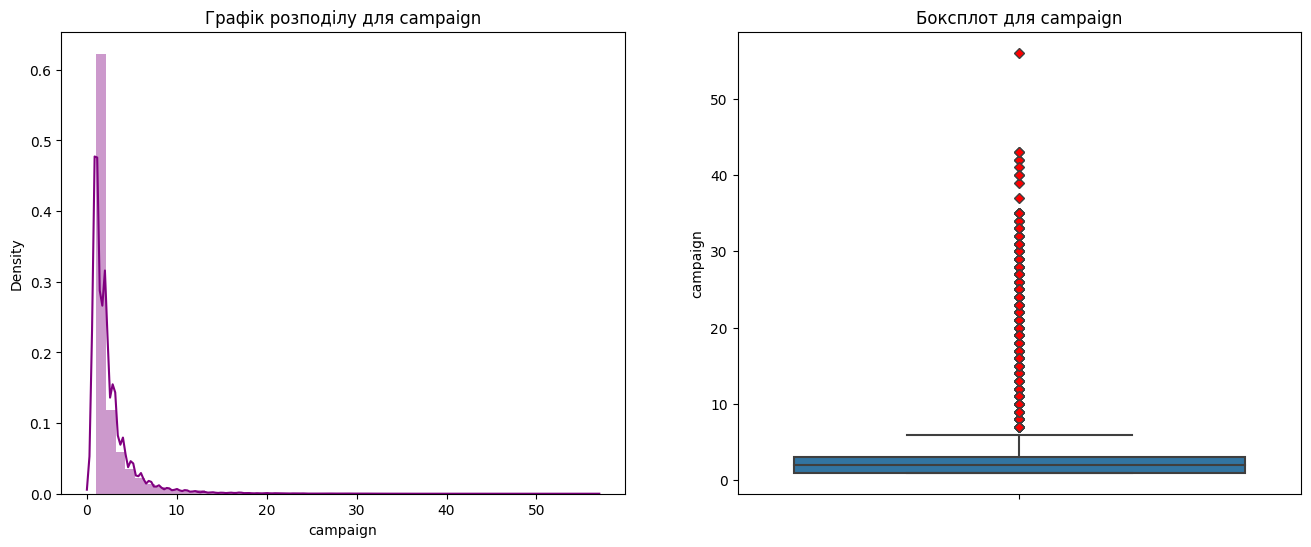

In [7]:
dist_box(df,'campaign')

In [8]:
df['campaign_log'] = np.log1p(df['campaign'])

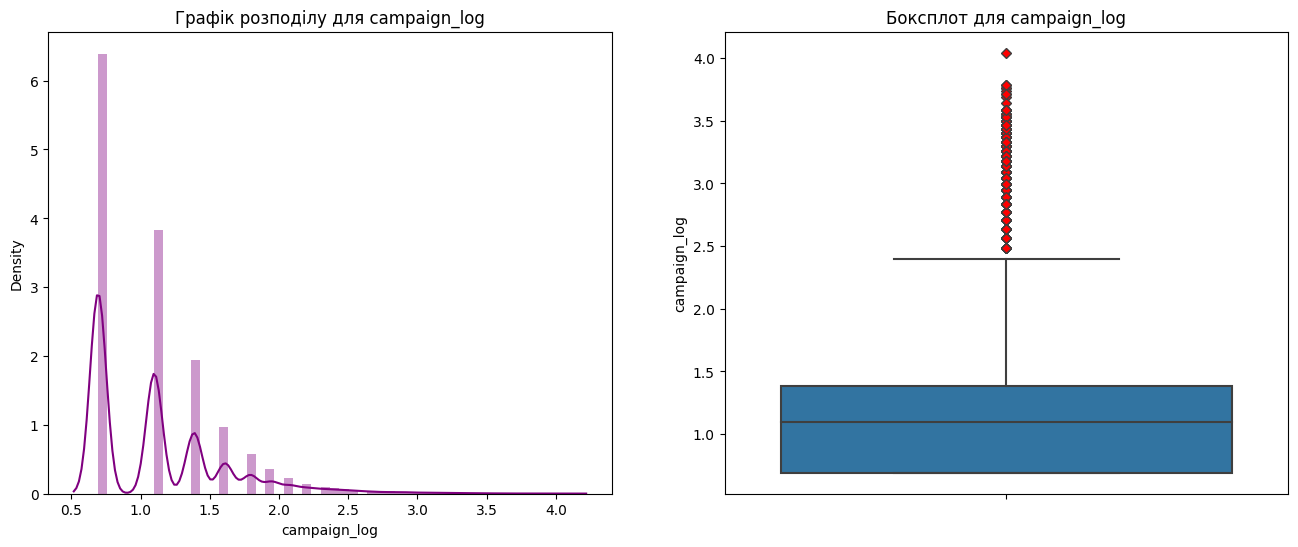

In [9]:
dist_box(df,'campaign_log')

**Розподіл мав «довгий хвіст», логарифмування дещо покращило ситуацію.**

In [10]:
# 1) варіант з NaN
df['pdays_nan'] = df['pdays'].replace(999, np.nan)

# 2) варіант з 0
df['pdays_zero'] = df['pdays'].replace(999, 0)

# 3) бінарний прапорець "не було контакту"
df['no_prev_contact'] = (df['pdays'] == 999).astype(int)

In [11]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

In [12]:
# категоризуємо age
df['age_cats'] = df['age'].apply(age_cat)
df['age_cats'].value_counts().sort_values(ascending = False)

30-40    16385
40-50    10240
20-30     7243
50-60     6270
60-70      488
70+        422
0-20       140
Name: age_cats, dtype: int64

In [13]:
def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='y')


def bi_countplot_target(df0, df1, column, hue_column):
  pltname = 'Клієнт, що підписав строковий депозит'
  print(pltname.upper())
  bi_cat_countplot(df1, column, hue_column)
  plt.show()

  pltname = 'Клієнт, що не підписав строковий депозит'
  print(pltname.upper())
  bi_cat_countplot(df0, column, hue_column)
  plt.show()

In [14]:
# категоріальні колонки
cat_cols = df.select_dtypes(include = "object").columns

for col in cat_cols:
    print("="*40)
    print(f"Колонка: {col}")
    print(df[col].value_counts(normalize = True) * 100)
    print("\n")

Колонка: job
admin.          25.30
blue-collar     22.47
technician      16.37
services         9.64
management       7.10
retired          4.18
entrepreneur     3.54
self-employed    3.45
housemaid        2.57
unemployed       2.46
student          2.12
unknown          0.80
Name: job, dtype: float64


Колонка: marital
married    60.52
single     28.09
divorced   11.20
unknown     0.19
Name: marital, dtype: float64


Колонка: education
university.degree     29.54
high.school           23.10
basic.9y              14.68
professional.course   12.73
basic.4y              10.14
basic.6y               5.56
unknown                4.20
illiterate             0.04
Name: education, dtype: float64


Колонка: default
no        79.12
unknown   20.87
yes        0.01
Name: default, dtype: float64


Колонка: housing
yes       52.38
no        45.21
unknown    2.40
Name: housing, dtype: float64


Колонка: loan
no        82.43
yes       15.17
unknown    2.40
Name: loan, dtype: float64


Колонка: contact

- **one-hot encoding для всіх категоріальних**

- **об’єднання значень (education: basic.* → basic, unkown в деяких випадках)**

In [15]:
df['education'] = df['education'].replace({
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'basic.9y': 'basic',
})

# default видаляємо через неінформативність
df = df.drop(columns=['default'])

In [16]:
def handle_unknowns(df, threshold: float = 0.03):
    """
    Якщо 'unknown' < threshold (частка), замінюємо на найбільш часту категорію.
    Інакше залишаємо як є.
    """
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in cat_cols:
        if "unknown" in df[col].values:
            freq = df[col].value_counts(normalize=True)
            unk_share = freq["unknown"]
            if unk_share < threshold:
                dominant = freq.drop("unknown").idxmax()
                df[col] = df[col].replace("unknown", dominant)
                print(f"{col}: 'unknown' ({unk_share:.2%}) → {dominant}")
            else:
                print(f"{col}: залишаємо 'unknown' ({unk_share:.2%})")

    return df

In [17]:
df = handle_unknowns(df, threshold=0.03)

job: 'unknown' (0.80%) → admin.
marital: 'unknown' (0.19%) → married
education: залишаємо 'unknown' (4.20%)
housing: 'unknown' (2.40%) → yes
loan: 'unknown' (2.40%) → no


In [18]:
# цільовий стовпець 'y'
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [19]:
df['y'].value_counts(normalize = True).sort_values(ascending = False) * 100

0   88.73
1   11.27
Name: y, dtype: float64

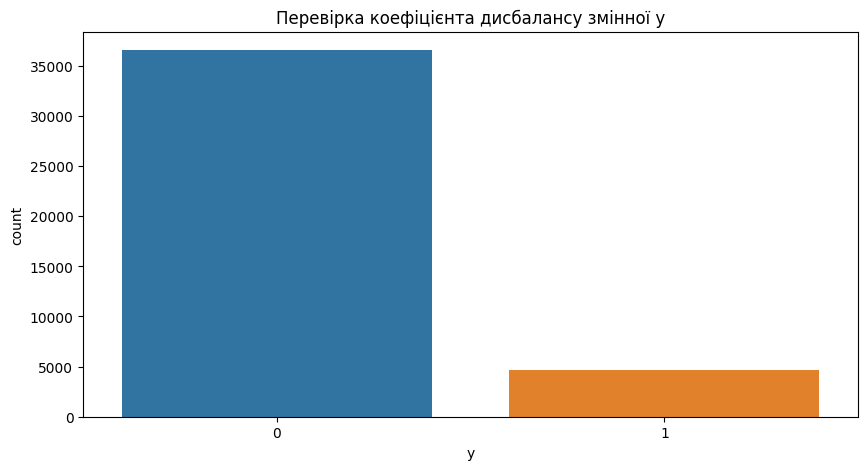

In [20]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['y'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної y')
plt.show()

- **маємо дисбаланс у змінній `y` на основі % спостережень**
- **значення `y` 1 - це клієнт, який підписав строковий депозит, лише 11,27% даних**
- **значення `y` 0 - всі інші випадки, 88,73% даних**

In [21]:
df1 = df[df['y'] == 1]
df0 = df[df['y'] == 0]

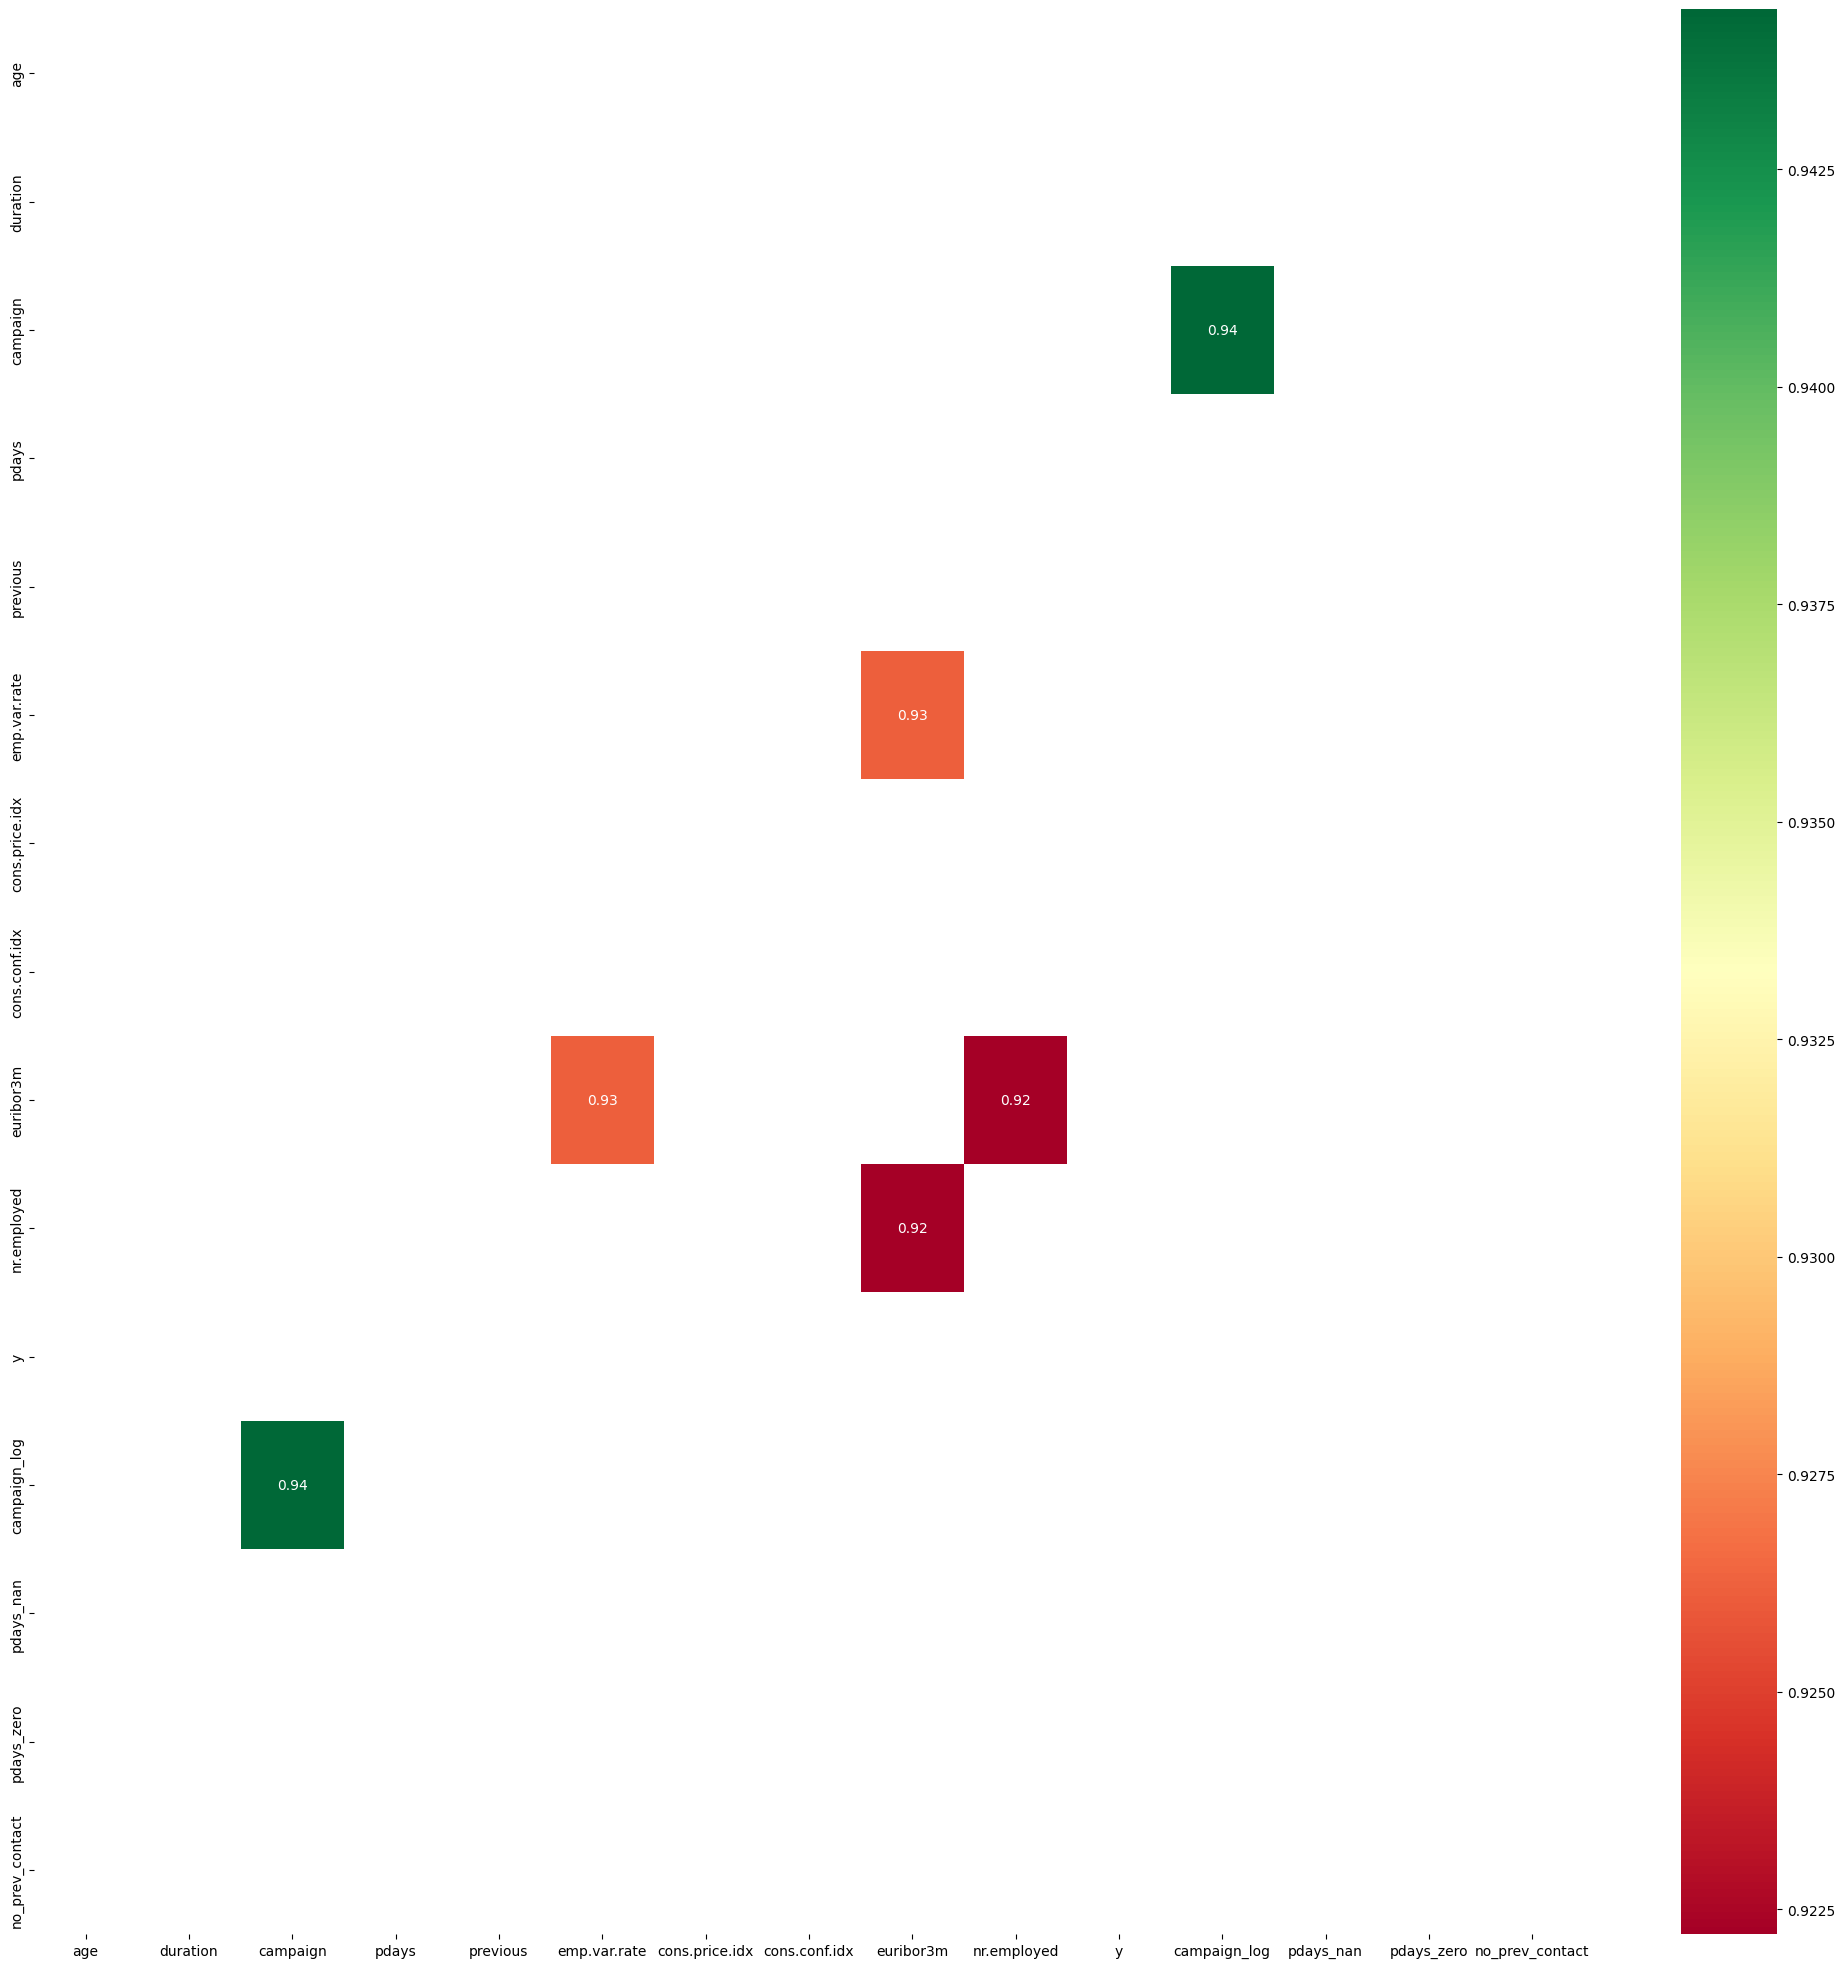

campaign         campaign_log      0.94
campaign_log     campaign          0.94
emp.var.rate     euribor3m         0.93
euribor3m        emp.var.rate      0.93
nr.employed      euribor3m         0.92
euribor3m        nr.employed       0.92
emp.var.rate     nr.employed       0.79
nr.employed      emp.var.rate      0.79
cons.price.idx   emp.var.rate      0.66
emp.var.rate     cons.price.idx    0.66
pdays_zero       previous          0.57
previous         pdays_zero        0.57
emp.var.rate     duration          0.50
duration         emp.var.rate      0.50
euribor3m        duration          0.50
duration         euribor3m         0.50
                 nr.employed       0.48
nr.employed      duration          0.48
                 no_prev_contact   0.45
no_prev_contact  nr.employed       0.45
pdays            nr.employed       0.45
nr.employed      pdays             0.45
dtype: float64

In [27]:
# Кореляційний аналіз числових змінних
corr_df1 = df1.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

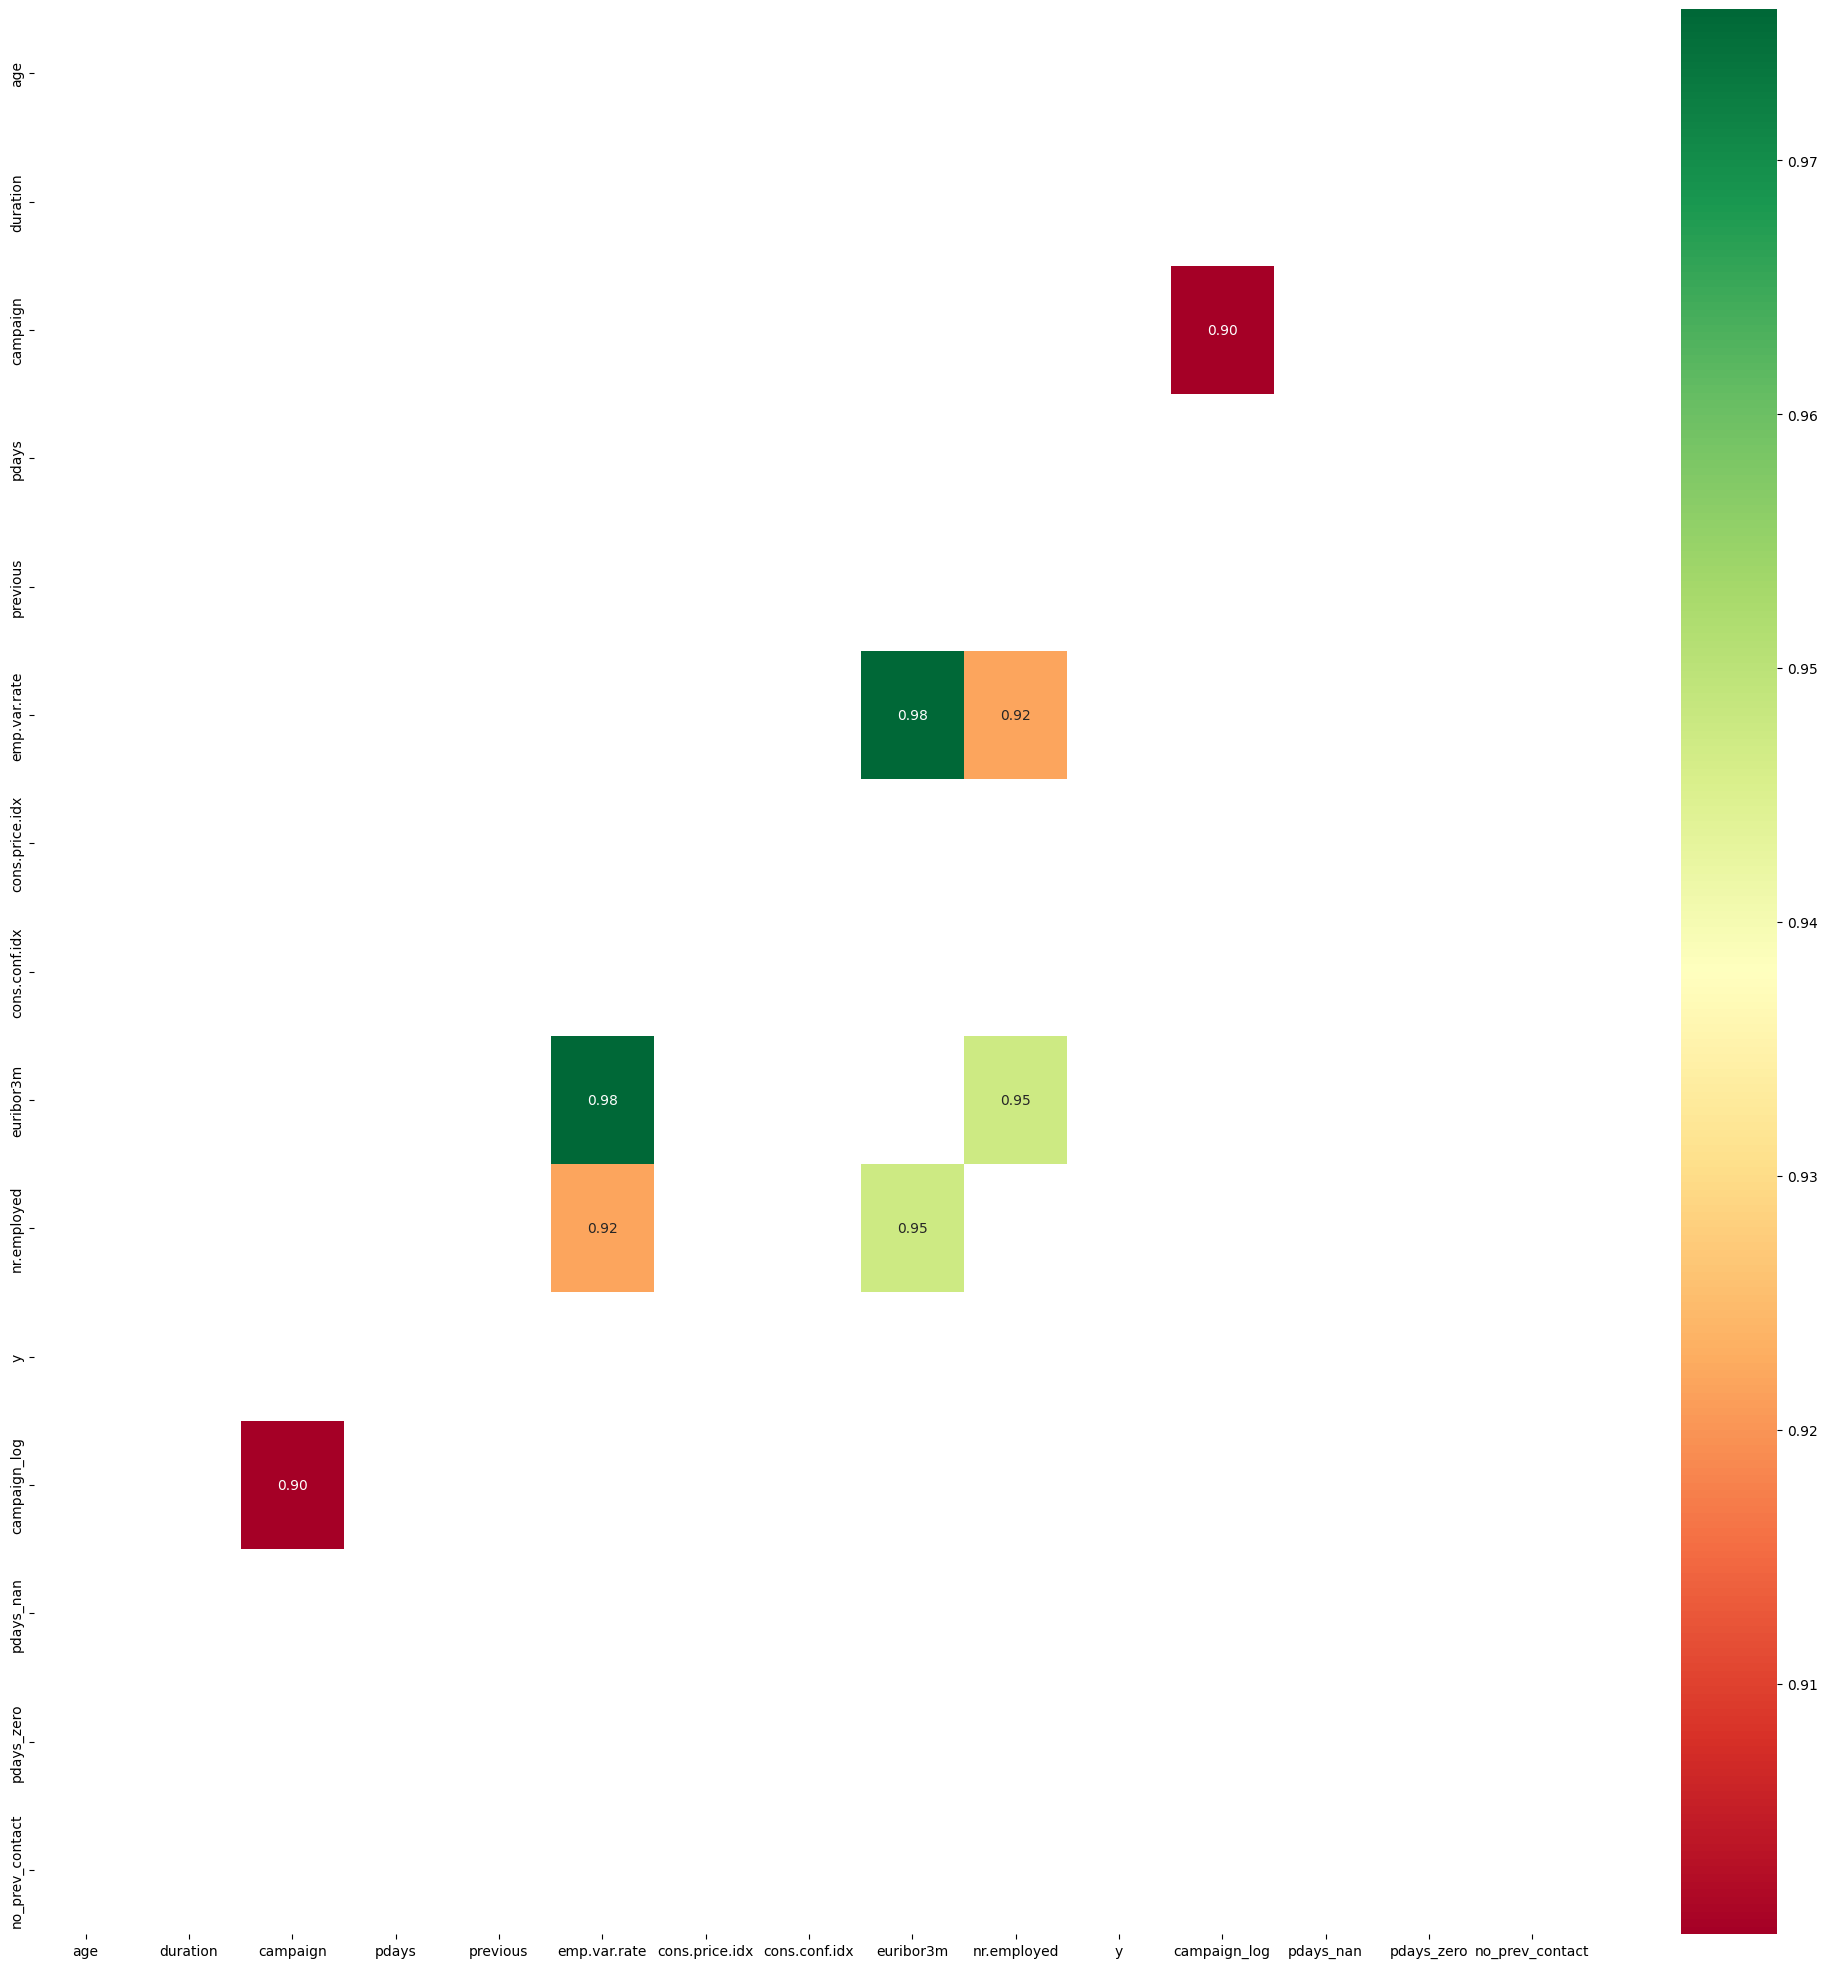

emp.var.rate     euribor3m         0.98
euribor3m        emp.var.rate      0.98
nr.employed      euribor3m         0.95
euribor3m        nr.employed       0.95
emp.var.rate     nr.employed       0.92
nr.employed      emp.var.rate      0.92
campaign_log     campaign          0.90
campaign         campaign_log      0.90
emp.var.rate     cons.price.idx    0.80
cons.price.idx   emp.var.rate      0.80
                 euribor3m         0.73
euribor3m        cons.price.idx    0.73
cons.price.idx   nr.employed       0.59
nr.employed      cons.price.idx    0.59
euribor3m        cons.conf.idx     0.39
cons.conf.idx    euribor3m         0.39
previous         pdays_zero        0.37
pdays_zero       previous          0.37
emp.var.rate     cons.conf.idx     0.32
cons.conf.idx    emp.var.rate      0.32
no_prev_contact  nr.employed       0.24
nr.employed      no_prev_contact   0.24
                 pdays             0.24
pdays            nr.employed       0.24
pdays_nan        cons.price.idx    0.22


In [28]:
corr_df0 = df0.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

**Сильна мультиколінеарність серед макроекономічних змінних, адже `emp.var.rate`, `euribor3m`, `nr.employed` фактично дублюють одне одного. Для Logistic Regression варто зробити відбір ознак, або можливо використати регуляризацію (L1/L2).**

In [29]:
def univariate_outlier_analysis(df0, df1, column):
    print(f"\n=== Аналіз змінної: {column} ===")

    # Для df1 — підписав строк депозит
    Q1_1 = df1[column].quantile(0.25)
    Q3_1 = df1[column].quantile(0.75)
    IQR_1 = Q3_1 - Q1_1
    Min_value1 = Q1_1 - 1.5 * IQR_1
    Max_value1 = Q3_1 + 1.5 * IQR_1

    print(f"[df1 - підписав] IQR = {IQR_1}")
    print(f"Мінімальне значення, до якого існують викиди: {Min_value1}")
    print(f"Максимальне значення, після якого існують викиди: {Max_value1}")

    # Для df0 — не підписав строк депозит
    Q1_0 = df0[column].quantile(0.25)
    Q3_0 = df0[column].quantile(0.75)
    IQR_0 = Q3_0 - Q1_0
    Min_value0 = Q1_0 - 1.5 * IQR_0
    Max_value0 = Q3_0 + 1.5 * IQR_0

    print(f"[df0 - не підписав] IQR = {IQR_0}")
    print(f"Мінімальне значення, до якого існують викиди: {Min_value0}")
    print(f"Максимальне значення, після якого існують викиди: {Max_value0}")

    # Побудова графіку KDE без викидів
    plt.figure(figsize=(14, 6))
    sns.kdeplot(df1[df1[column] <= Max_value1][column], label='Signed')
    sns.kdeplot(df0[df0[column] <= Max_value0][column], label='Did not Sign')
    plt.ticklabel_format(style='plain', axis='x')
    plt.xticks(rotation=45)
    plt.title(f"KDE без викидів для: {column}")
    plt.legend()
    plt.show()


=== Аналіз змінної: age ===
[df1 - підписав] IQR = 19.0
Мінімальне значення, до якого існують викиди: 2.5
Максимальне значення, після якого існують викиди: 78.5
[df0 - не підписав] IQR = 15.0
Мінімальне значення, до якого існують викиди: 9.5
Максимальне значення, після якого існують викиди: 69.5


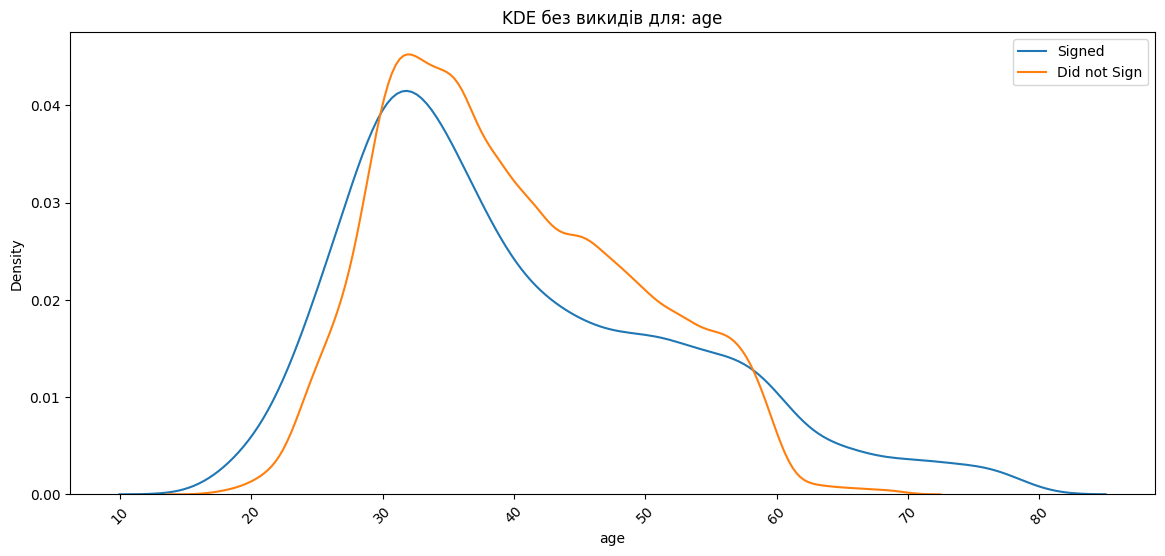


=== Аналіз змінної: duration ===
[df1 - підписав] IQR = 488.25
Мінімальне значення, до якого існують викиди: -479.375
Максимальне значення, після якого існують викиди: 1473.625
[df0 - не підписав] IQR = 184.0
Мінімальне значення, до якого існують викиди: -181.0
Максимальне значення, після якого існують викиди: 555.0


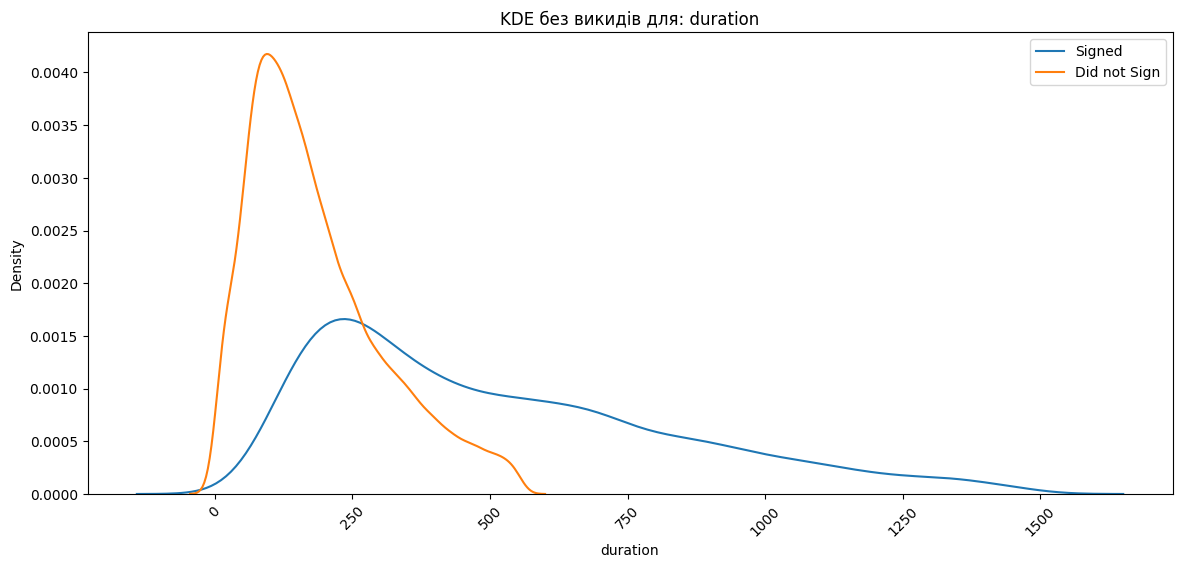


=== Аналіз змінної: campaign ===
[df1 - підписав] IQR = 1.0
Мінімальне значення, до якого існують викиди: -0.5
Максимальне значення, після якого існують викиди: 3.5
[df0 - не підписав] IQR = 2.0
Мінімальне значення, до якого існують викиди: -2.0
Максимальне значення, після якого існують викиди: 6.0


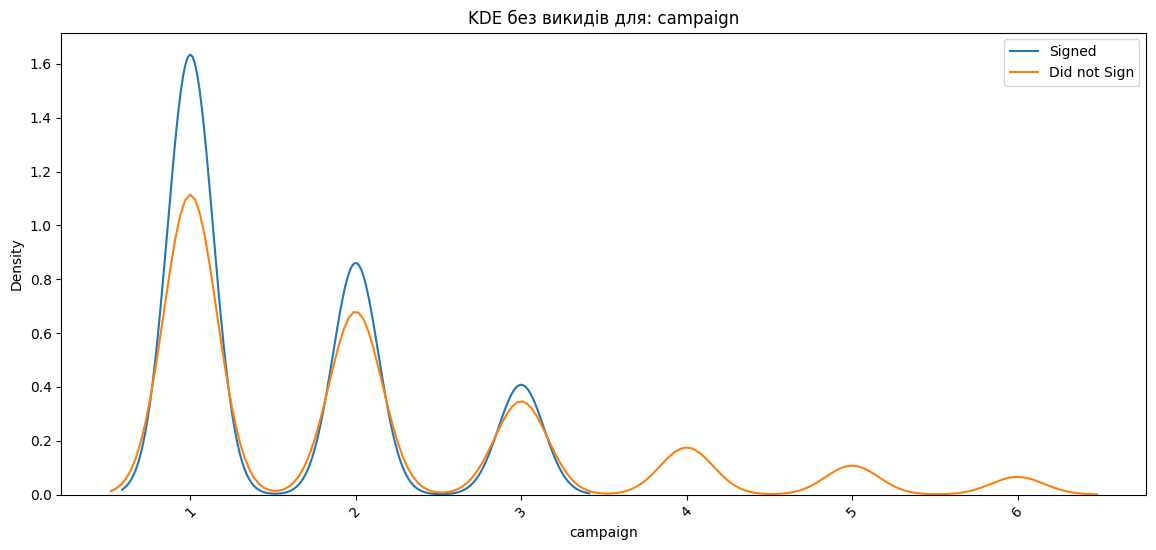


=== Аналіз змінної: pdays ===
[df1 - підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 999.0
Максимальне значення, після якого існують викиди: 999.0
[df0 - не підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 999.0
Максимальне значення, після якого існують викиди: 999.0


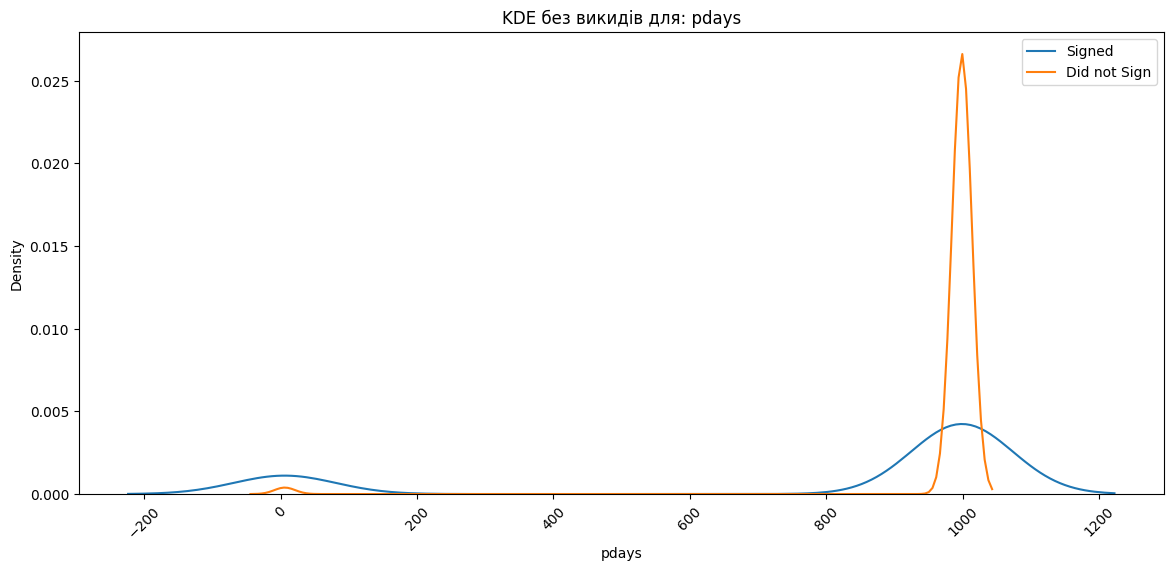


=== Аналіз змінної: previous ===
[df1 - підписав] IQR = 1.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5
[df0 - не підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 0.0
Максимальне значення, після якого існують викиди: 0.0


/var/folders/m_/08q67_2569g7rxl_d8m9kk2r0000gn/T/ipykernel_2847/2068873015.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df0[df0[column] <= Max_value0][column], label='Did not Sign')


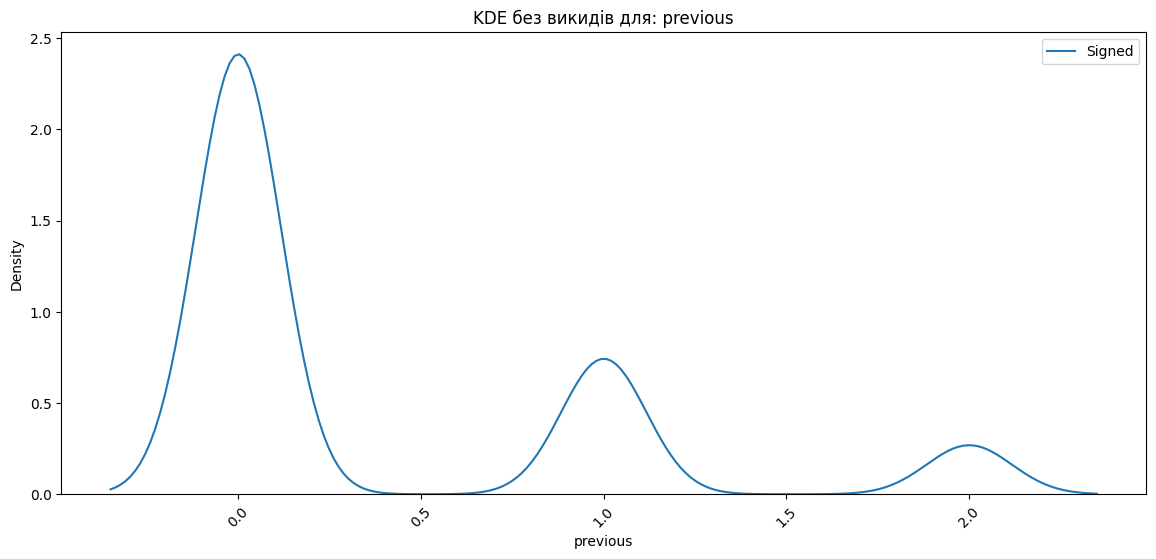


=== Аналіз змінної: emp.var.rate ===
[df1 - підписав] IQR = 1.7
Мінімальне значення, до якого існують викиди: -4.35
Максимальне значення, після якого існують викиди: 2.4499999999999997
[df0 - не підписав] IQR = 3.2
Мінімальне значення, до якого існують викиди: -6.6000000000000005
Максимальне значення, після якого існують викиди: 6.200000000000001


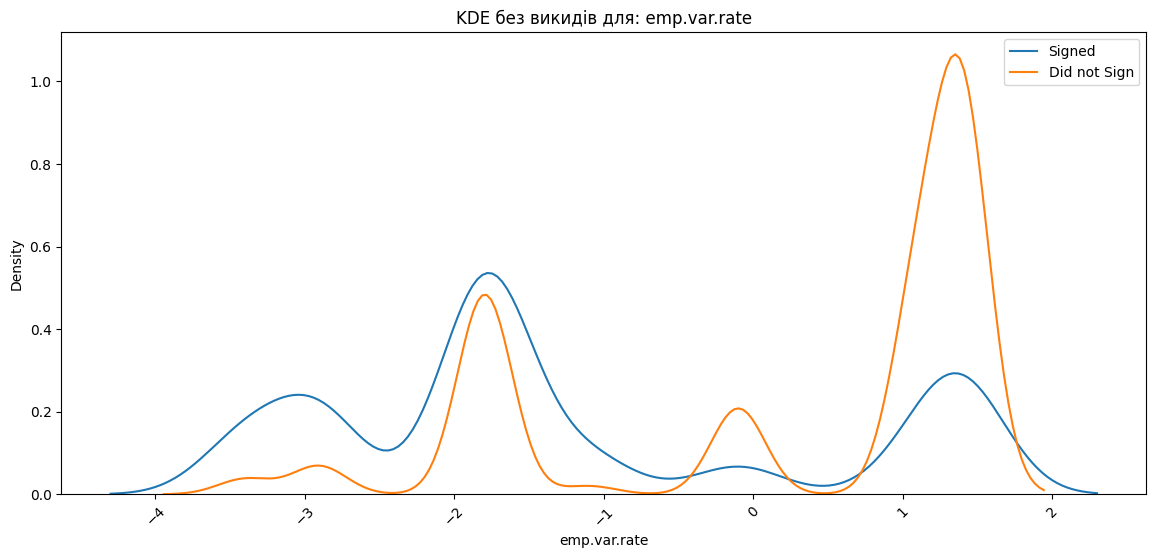


=== Аналіз змінної: cons.price.idx ===
[df1 - підписав] IQR = 1.0250000000000057
Мінімальне значення, до якого існують викиди: 91.35549999999999
Максимальне значення, після якого існують викиди: 95.45550000000001
[df0 - не підписав] IQR = 0.9189999999999969
Мінімальне значення, до якого існують викиди: 91.69650000000001
Максимальне значення, після якого існують викиди: 95.3725


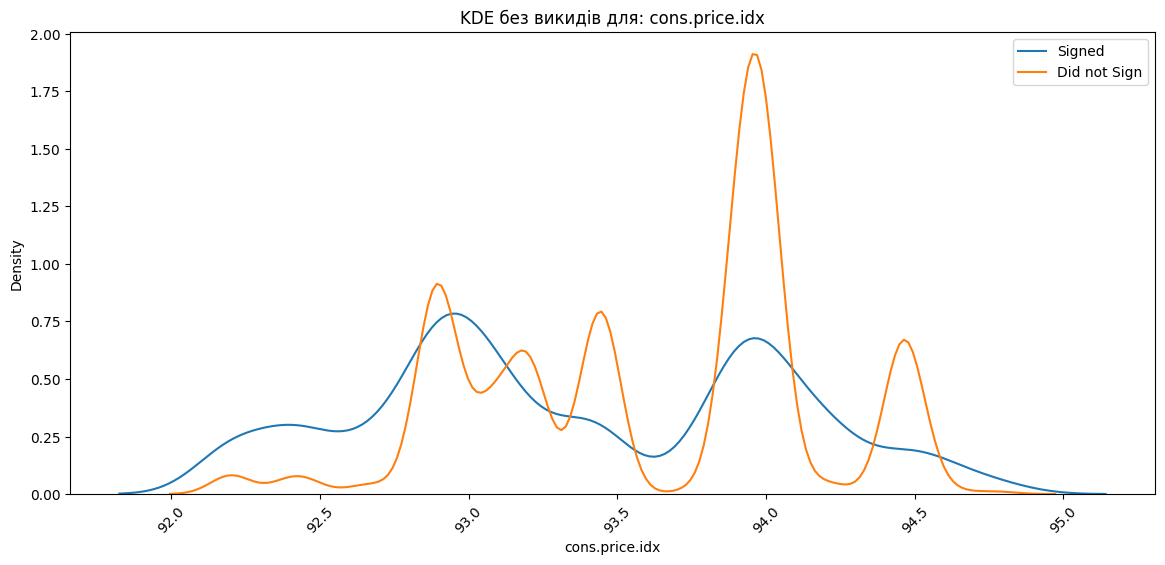


=== Аналіз змінної: cons.conf.idx ===
[df1 - підписав] IQR = 10.100000000000001
Мінімальне значення, до якого існують викиди: -61.35000000000001
Максимальне значення, після якого існують викиди: -20.95
[df0 - не підписав] IQR = 6.300000000000004
Мінімальне значення, до якого існують викиди: -52.150000000000006
Максимальне значення, після якого існують викиди: -26.949999999999992


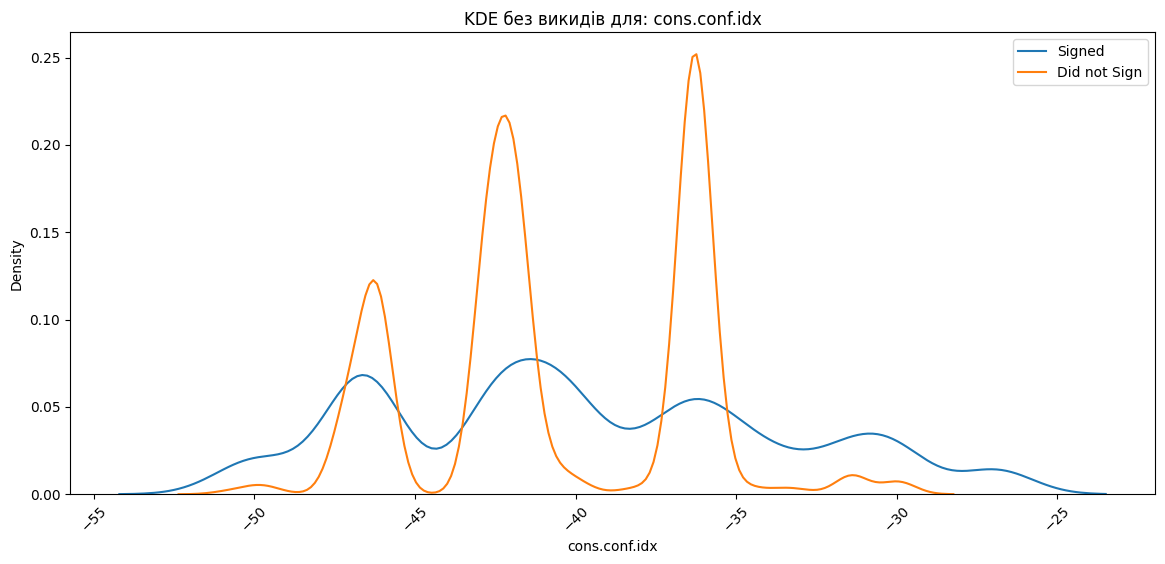


=== Аналіз змінної: euribor3m ===
[df1 - підписав] IQR = 3.5569999999999995
Мінімальне значення, до якого існують викиди: -4.4864999999999995
Максимальне значення, після якого існують викиди: 9.741499999999998
[df0 - не підписав] IQR = 3.5569999999999995
Мінімальне значення, до якого існують викиди: -3.9304999999999994
Максимальне значення, після якого існують викиди: 10.2975


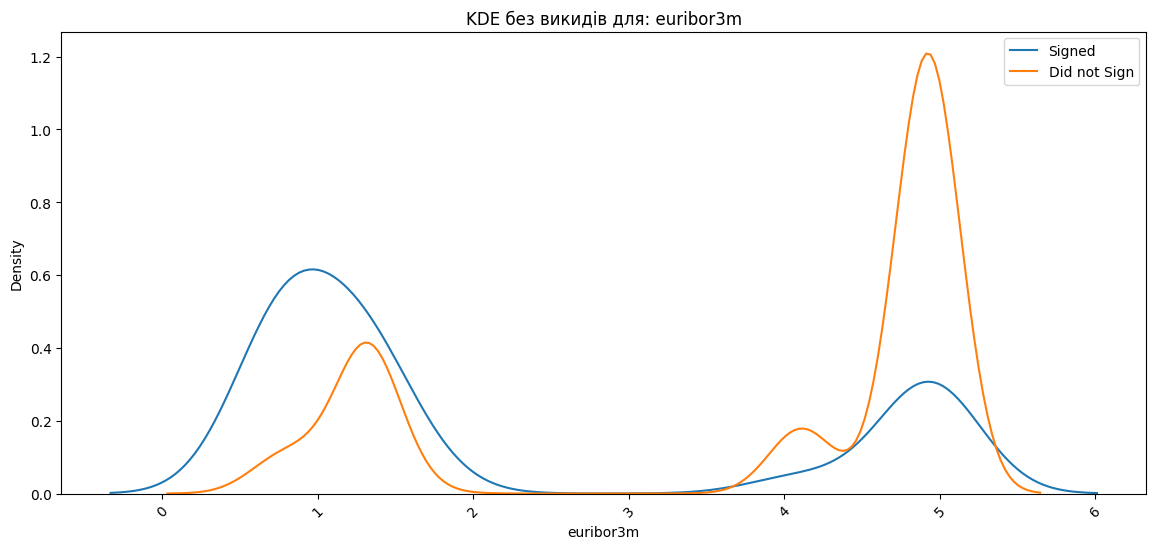


=== Аналіз змінної: nr.employed ===
[df1 - підписав] IQR = 173.5
Мінімальне значення, до якого існують викиди: 4757.25
Максимальне значення, після якого існують викиди: 5451.25
[df0 - не підписав] IQR = 129.0
Мінімальне значення, до якого існують викиди: 4905.6
Максимальне значення, після якого існують викиди: 5421.6


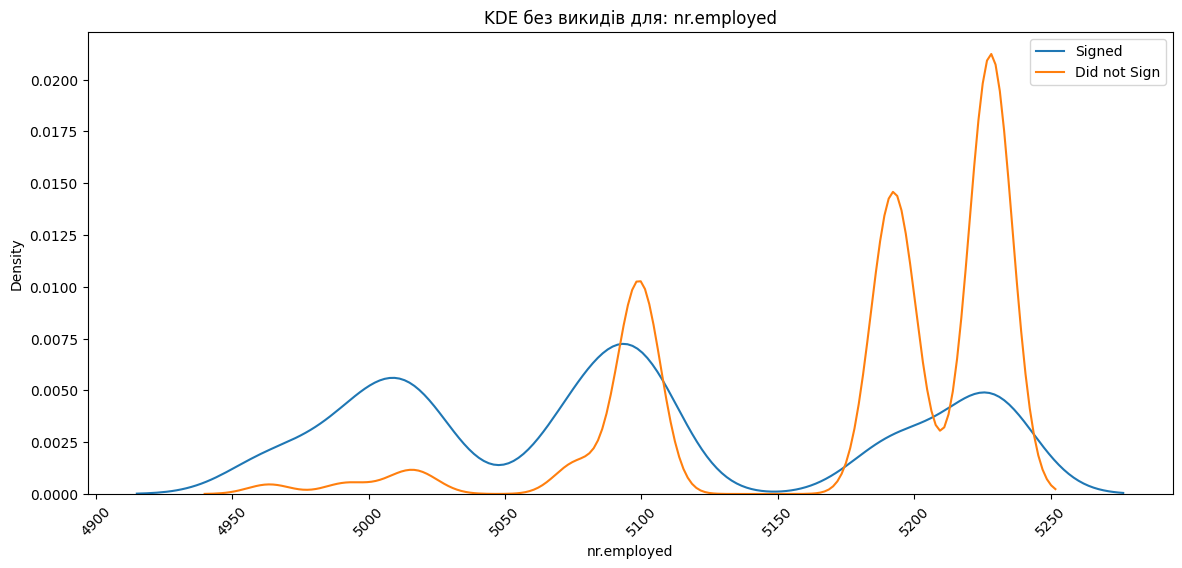


=== Аналіз змінної: campaign_log ===
[df1 - підписав] IQR = 0.4054651081081645
Мінімальне значення, до якого існують викиди: 0.0849495183976986
Максимальне значення, після якого існують викиди: 1.7068099508303565
[df0 - не підписав] IQR = 0.6931471805599453
Мінімальне значення, до якого існують викиди: -0.3465735902799726
Максимальне значення, після якого існують викиди: 2.4260151319598084


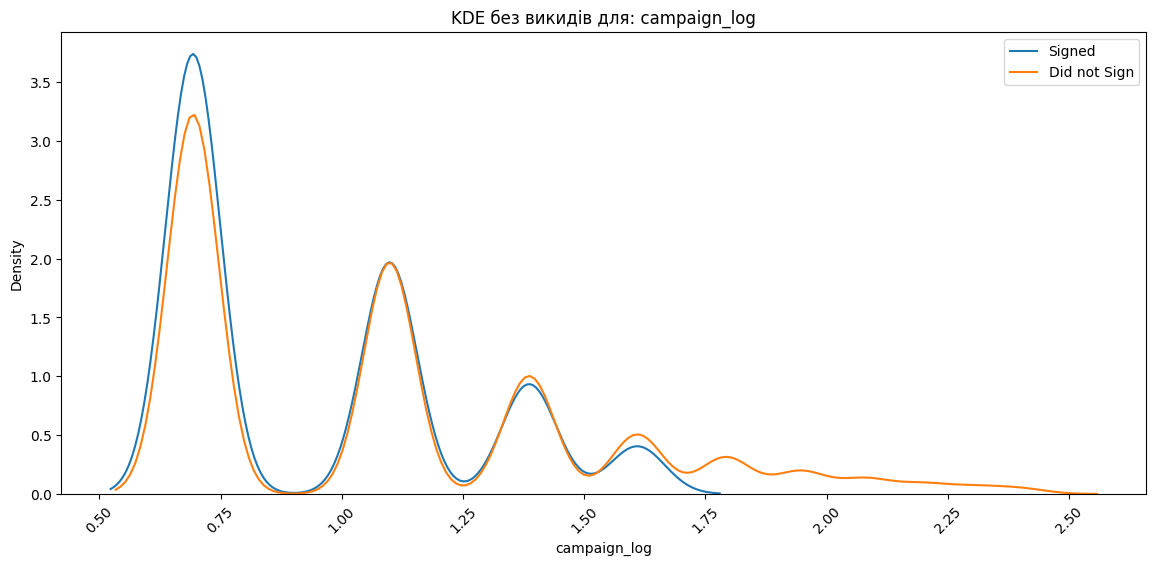


=== Аналіз змінної: pdays_nan ===
[df1 - підписав] IQR = 3.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 10.5
[df0 - не підписав] IQR = 6.0
Мінімальне значення, до якого існують викиди: -6.0
Максимальне значення, після якого існують викиди: 18.0


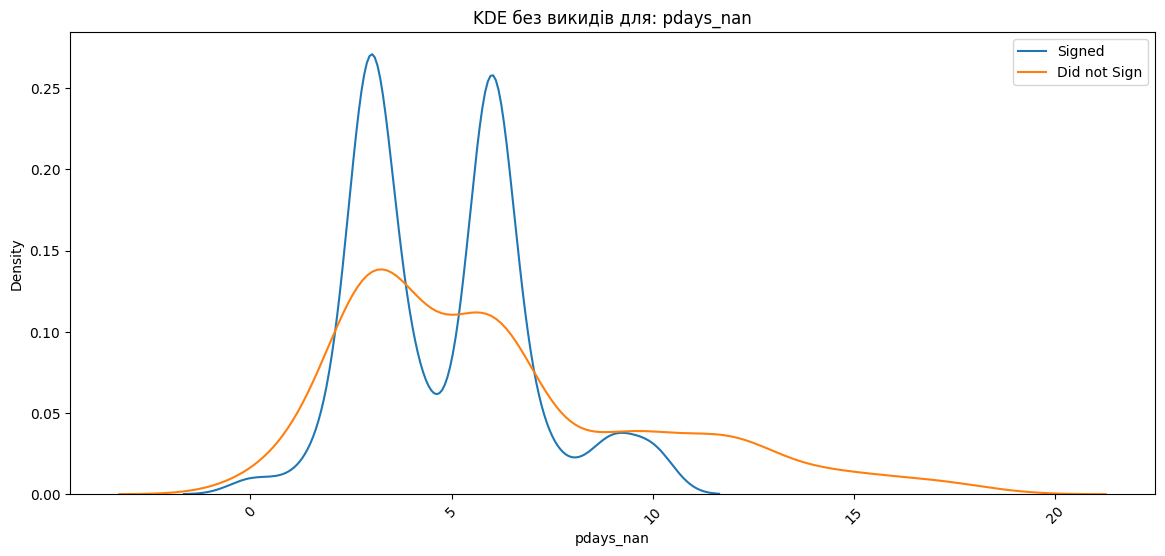


=== Аналіз змінної: pdays_zero ===
[df1 - підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 0.0
Максимальне значення, після якого існують викиди: 0.0
[df0 - не підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 0.0
Максимальне значення, після якого існують викиди: 0.0


/var/folders/m_/08q67_2569g7rxl_d8m9kk2r0000gn/T/ipykernel_2847/2068873015.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[df1[column] <= Max_value1][column], label='Signed')
/var/folders/m_/08q67_2569g7rxl_d8m9kk2r0000gn/T/ipykernel_2847/2068873015.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df0[df0[column] <= Max_value0][column], label='Did not Sign')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


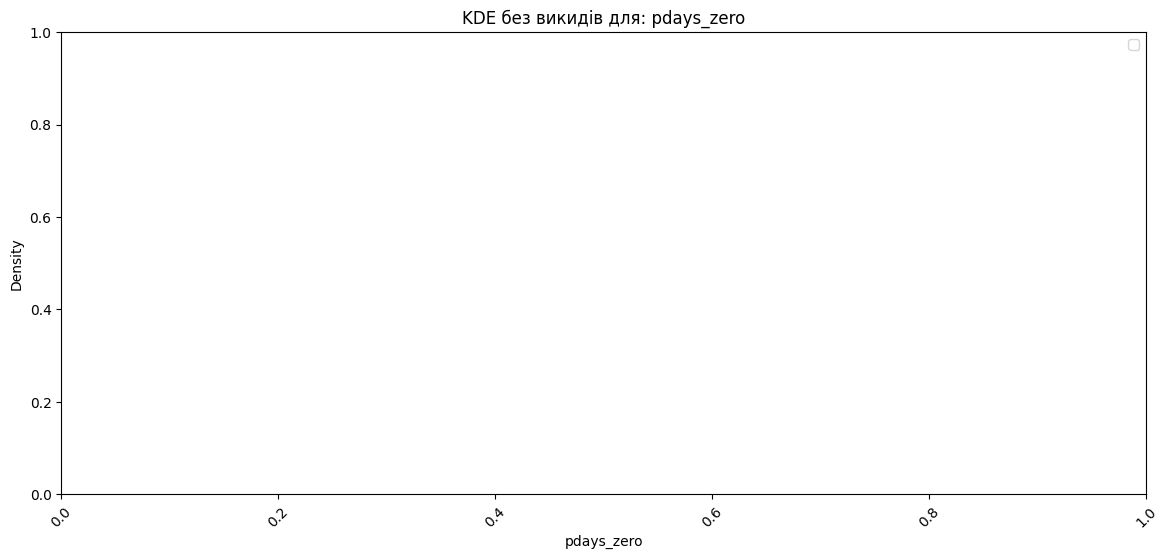


=== Аналіз змінної: no_prev_contact ===
[df1 - підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 1.0
Максимальне значення, після якого існують викиди: 1.0
[df0 - не підписав] IQR = 0.0
Мінімальне значення, до якого існують викиди: 1.0
Максимальне значення, після якого існують викиди: 1.0


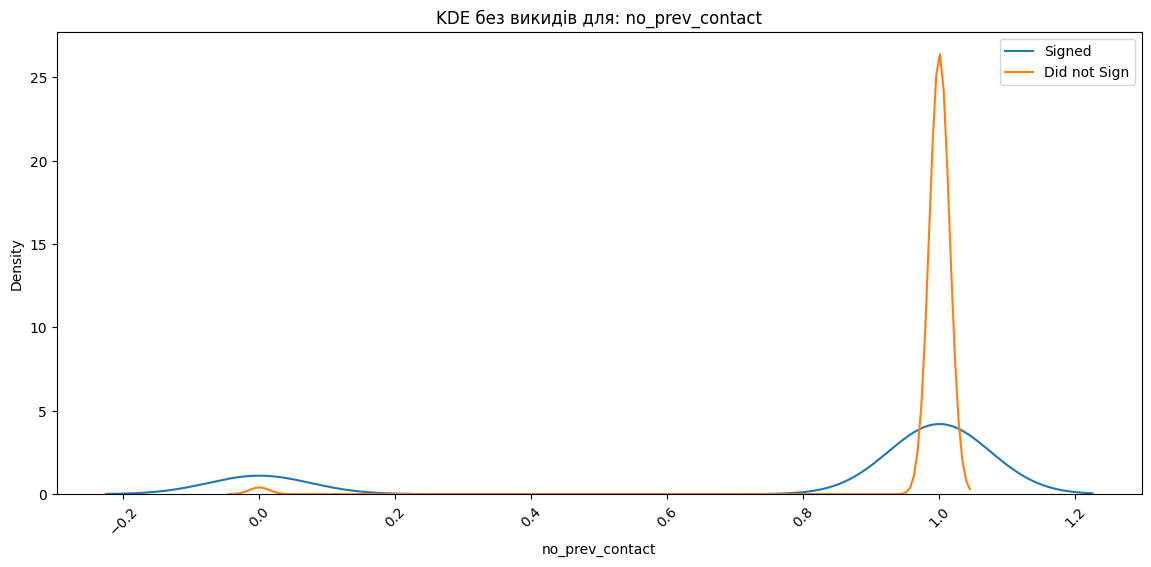

In [30]:
# Одновимірний аналіз числових змінних
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop('y')

for col in num_cols:
    univariate_outlier_analysis(df0, df1, col)

- **По age різниця між групами невелика, але є тренд, що вікові групи від 30 до 60 частіше не підписують.**
- **По campaign у тих, хто підписав, частіше 1–2 дзвінки.**
- **По emp.var.rate більш охоче підписували під час економічного спаду, а не зростання.**
- **Згідно з euribor3m низькі відсоткові ставки стимулюють людей підписувати депозити.**
- **Чим менше працевлаштованих, тим більше клієнти схильні вкладати в депозити.**
- **Вплив cons.price.idx є, але менш виражений.**
- **Hижча довіра споживачів трохи підвищує шанси підписання депозиту.**

Аналіз для категоріальної змінної: job


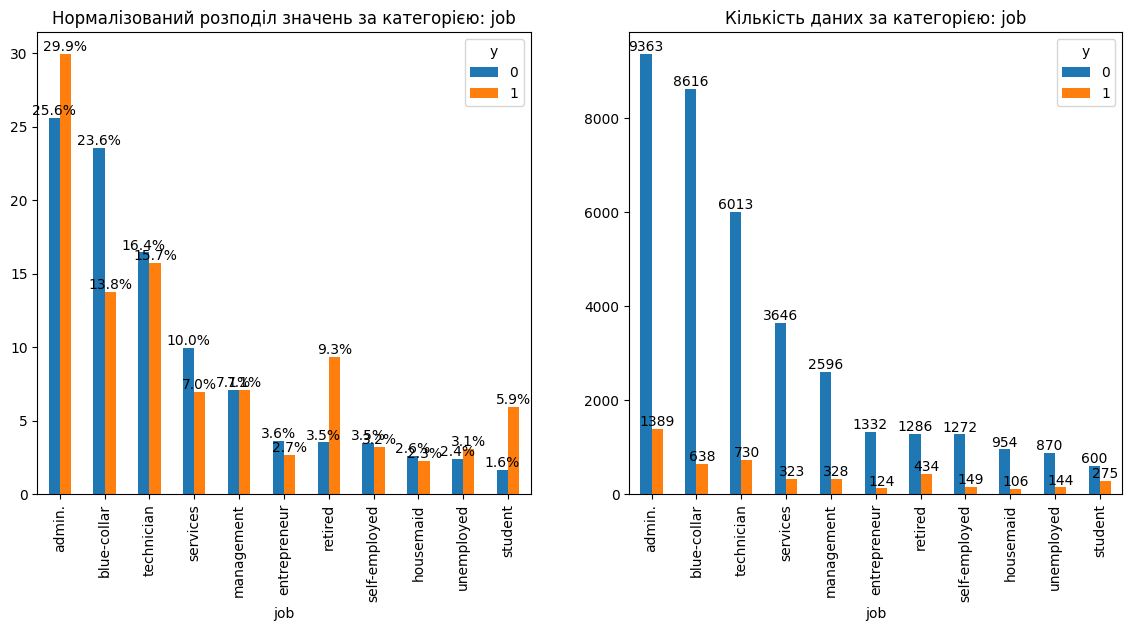

Аналіз для категоріальної змінної: marital


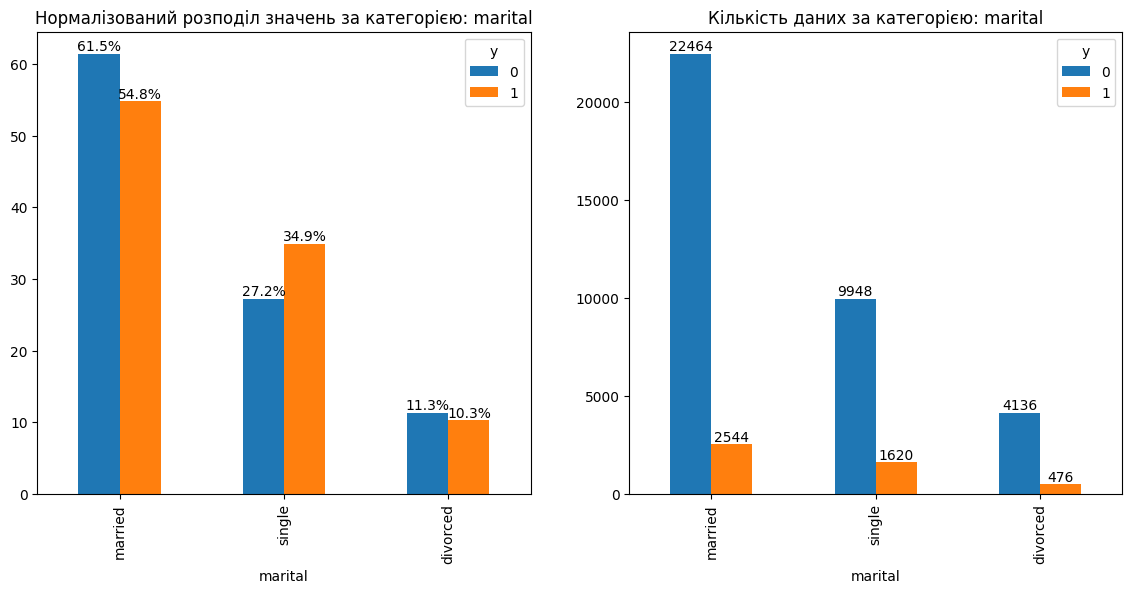

Аналіз для категоріальної змінної: education


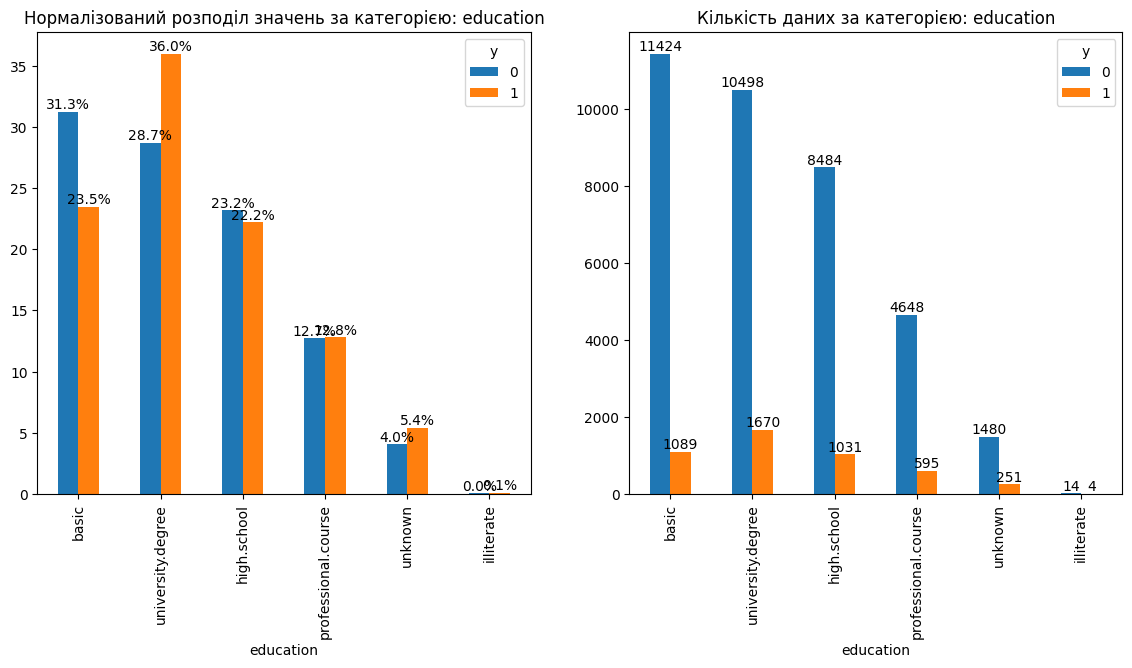

Аналіз для категоріальної змінної: housing


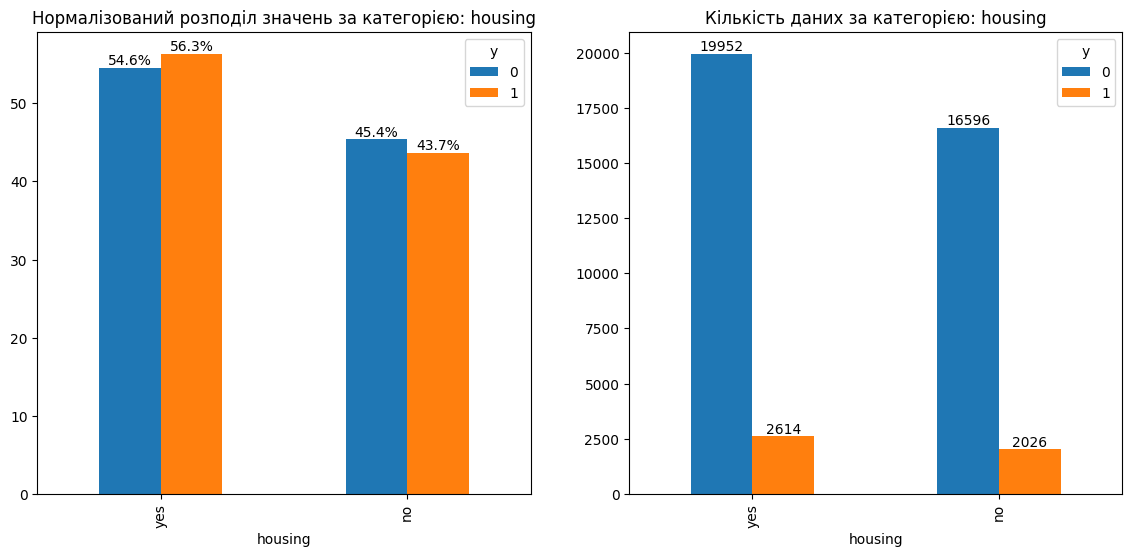

Аналіз для категоріальної змінної: loan


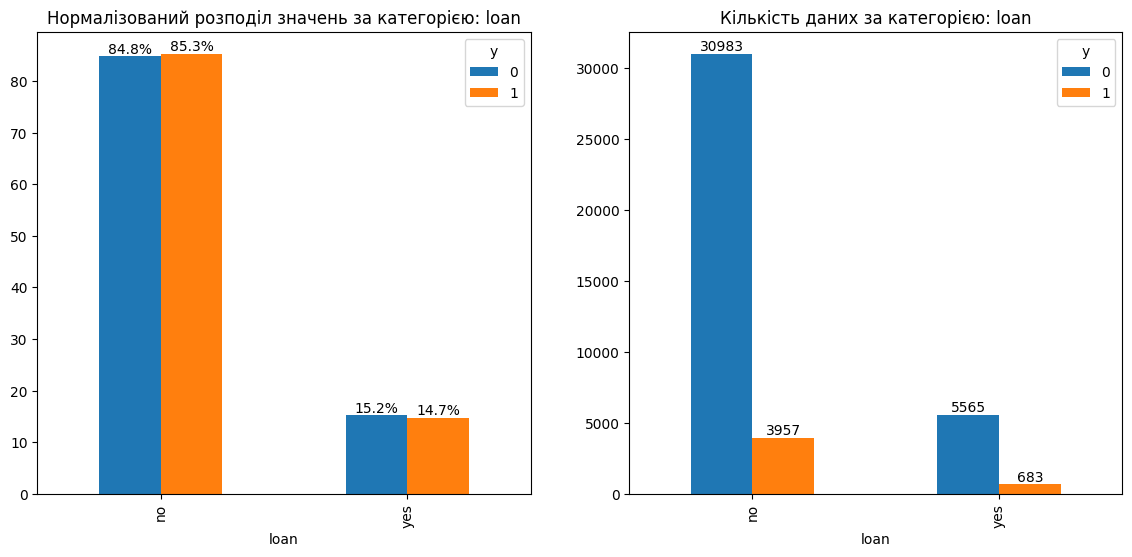

Аналіз для категоріальної змінної: contact


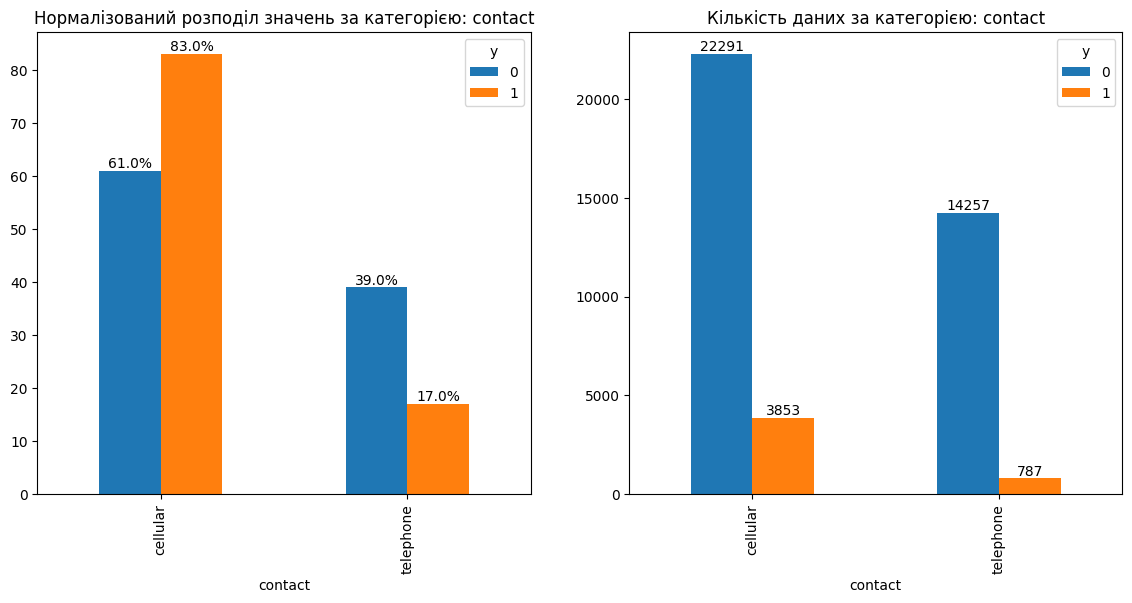

Аналіз для категоріальної змінної: month


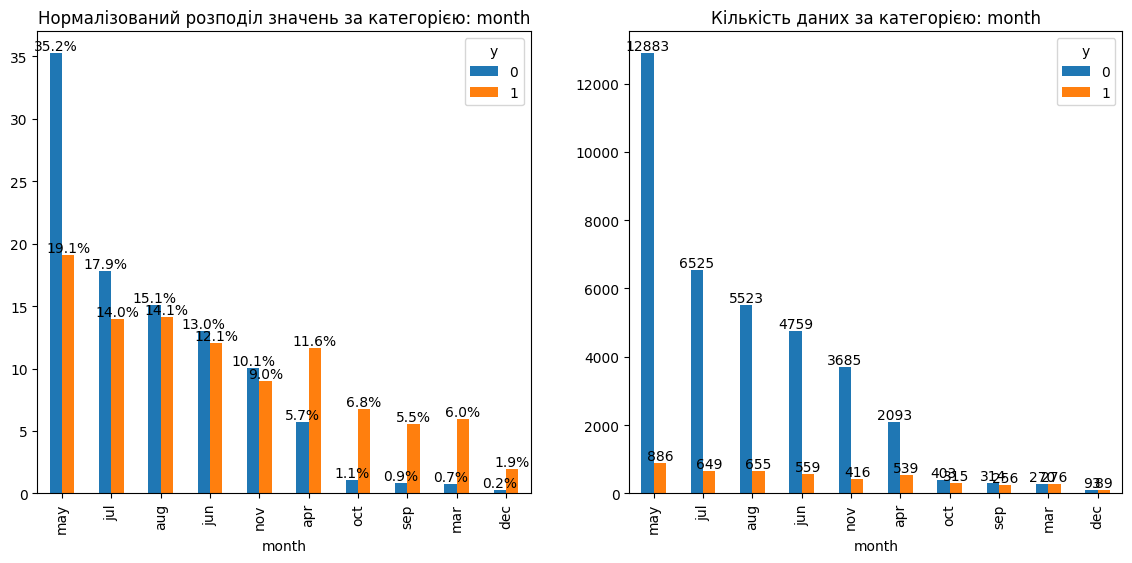

Аналіз для категоріальної змінної: day_of_week


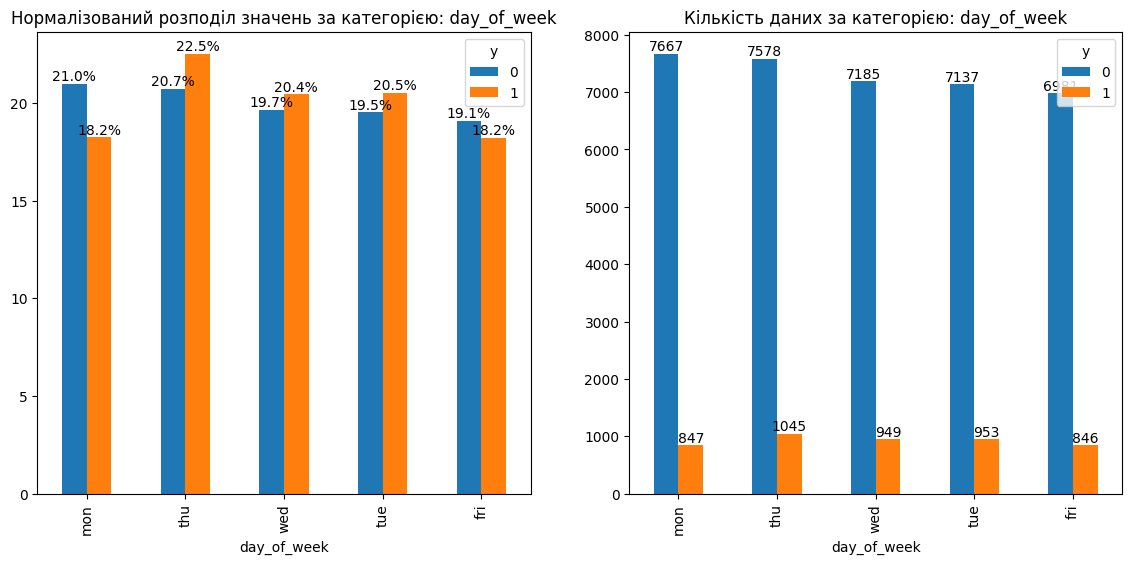

Аналіз для категоріальної змінної: poutcome


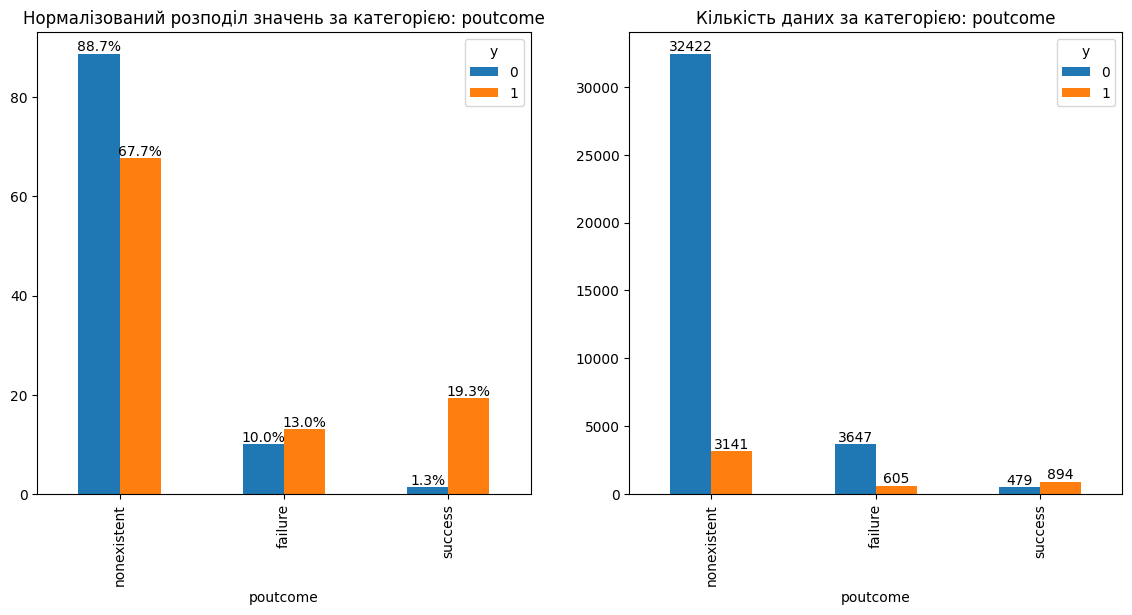

Аналіз для категоріальної змінної: age_cats


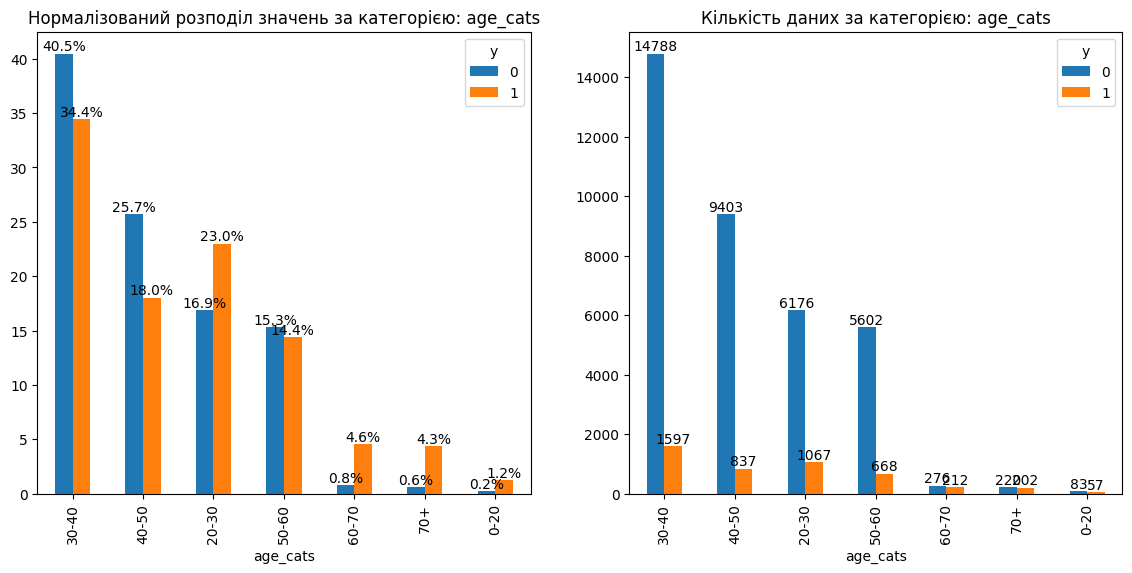

In [26]:
cat_cols2 = df.select_dtypes(include="object").columns

# Одномірний аналіз категоріальних змінних
for col in cat_cols2:
    print("="*80)
    print(f"Аналіз для категоріальної змінної: {col}")
    uni_cat_target_compare(df, col)
    plt.show()

**Особливо інформативними можуть бути змінні `job`, `marital`, `education`, `contact`, `month`, `poutcome`, `age_cats`. Саме в них бачимо суттєві відмінності між клієнтами, які підписали строковий депозит або ні.**

In [43]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(16, 10))

    # Графік для першої групи 
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Signed', hue_column, 1)

    # Графік для другої групи 
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'Not Signed', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()
    
def numeric_vs_categorical_analysis(df0, df1, column_1, column_2, column_3):
  max_value1_column_1 = outlier_range_max(df1, column_1)
  max_value0_column_1 = outlier_range_max(df0, column_1)

  # Клієнт з платіжними труднощами

  display(df1.groupby(by = [column_2, column_3])[column_1].describe().head())

  # Клієнт зі своєчасними платежами

  display(df0.groupby(by = [column_2, column_3])[column_1].describe().head())

  bi_boxplot(column_2, column_1, max_value1_column_1, max_value0_column_1, column_3)

count  mean   std   min   25%   50%   75%   max
job         marital                                                  
admin.      divorced 135.00 45.58  9.62 28.00 39.00 45.00 52.00 81.00
            married  673.00 41.80 10.57 23.00 33.00 39.00 50.00 78.00
            single   581.00 32.34  6.96 21.00 28.00 31.00 35.00 59.00
blue-collar divorced  53.00 42.04  9.24 28.00 34.00 40.00 50.00 59.00
            married  424.00 41.33  9.19 21.00 33.00 41.00 49.00 70.00

count  mean  std   min   25%   50%   75%   max
job         marital                                                  
admin.      divorced 1158.00 43.10 8.51 25.00 36.00 43.00 50.00 70.00
            married  4837.00 40.47 8.79 21.00 33.00 39.00 47.00 78.00
            single   3368.00 33.94 6.95 20.00 29.00 32.00 37.00 61.00
blue-collar divorced  675.00 42.90 8.10 24.00 37.00 42.00 49.00 71.00
            married  6277.00 40.86 8.48 20.00 34.00 40.00 47.00 80.00

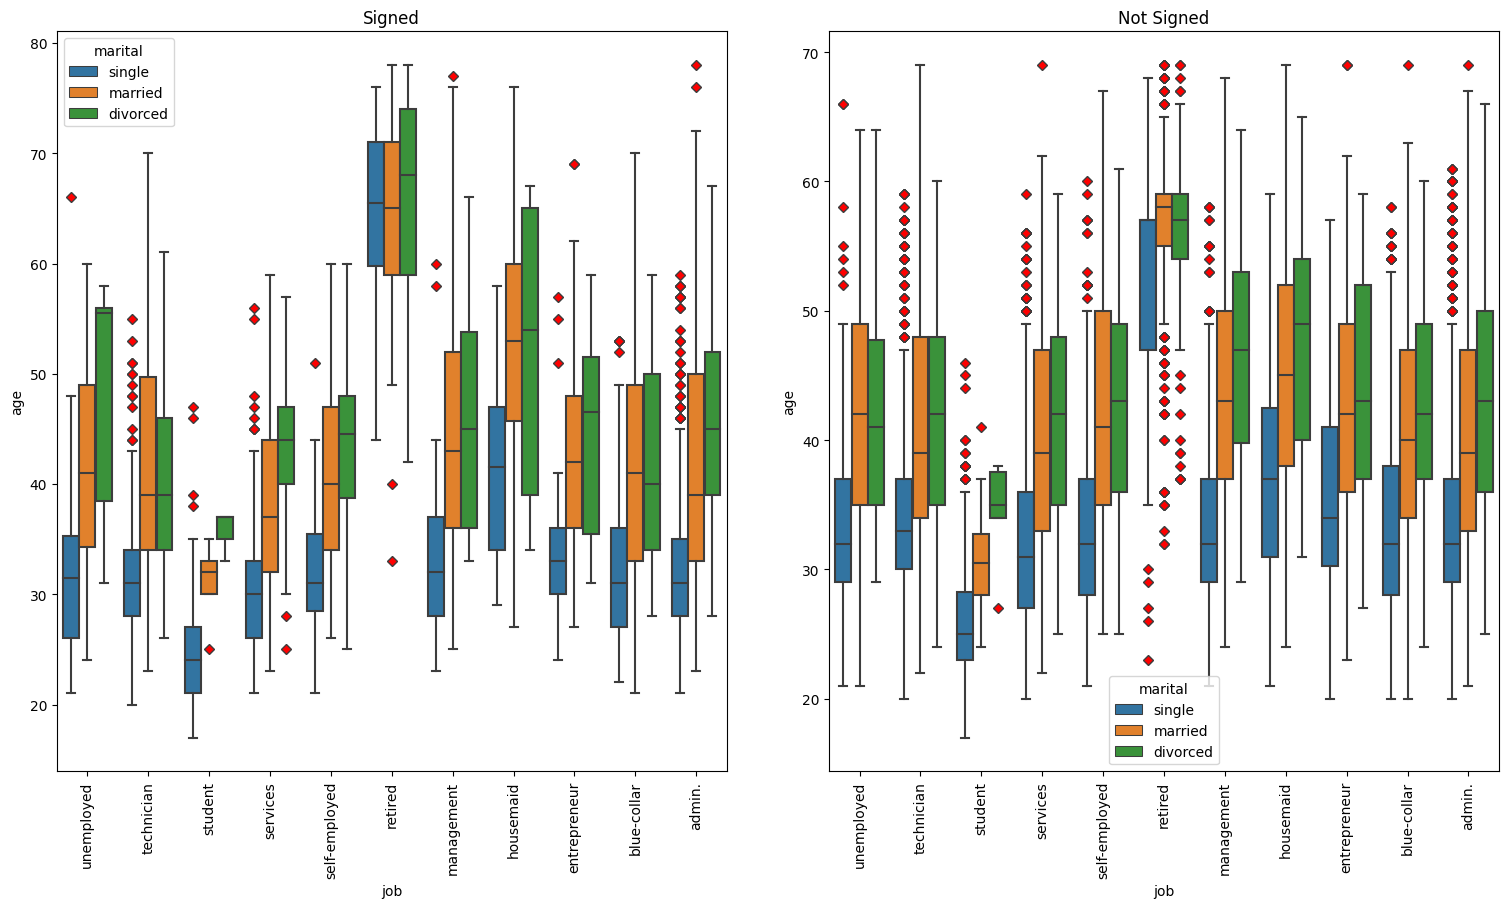

In [44]:
# Неперервні та категоріальні змінні
numeric_vs_categorical_analysis(df0, df1, "age", "job", "marital")

**Пенсіонери у групі Signed виглядають цікаво — вік у них значно вищий, але вони все ж підписали депозити.**

count   mean  std    min    25%    50%    75%    max
marital  age_cats                                                      
divorced 20-30     18.00 -43.83 3.11 -47.10 -46.20 -44.45 -41.85 -36.10
         30-40    135.00 -41.11 5.17 -50.80 -46.20 -42.00 -36.40 -29.80
         40-50    126.00 -40.59 5.36 -50.80 -46.20 -40.60 -36.40 -29.80
         50-60    112.00 -39.31 6.23 -50.80 -42.70 -40.80 -34.35 -26.90
         60-70     25.00 -39.32 7.44 -50.80 -47.10 -38.30 -34.80 -26.90

count   mean  std    min    25%    50%    75%    max
marital  age_cats                                                       
divorced 20-30     211.00 -41.10 3.96 -47.10 -42.70 -42.00 -36.40 -26.90
         30-40    1370.00 -41.05 4.18 -50.80 -42.70 -42.00 -36.40 -26.90
         40-50    1422.00 -40.73 4.04 -50.80 -42.70 -41.80 -36.40 -26.90
         50-60    1038.00 -40.68 4.04 -50.80 -42.70 -42.00 -36.40 -26.90
         60-70      30.00 -37.78 8.03 -50.80 -46.88 -34.20 -31.40 -26.90

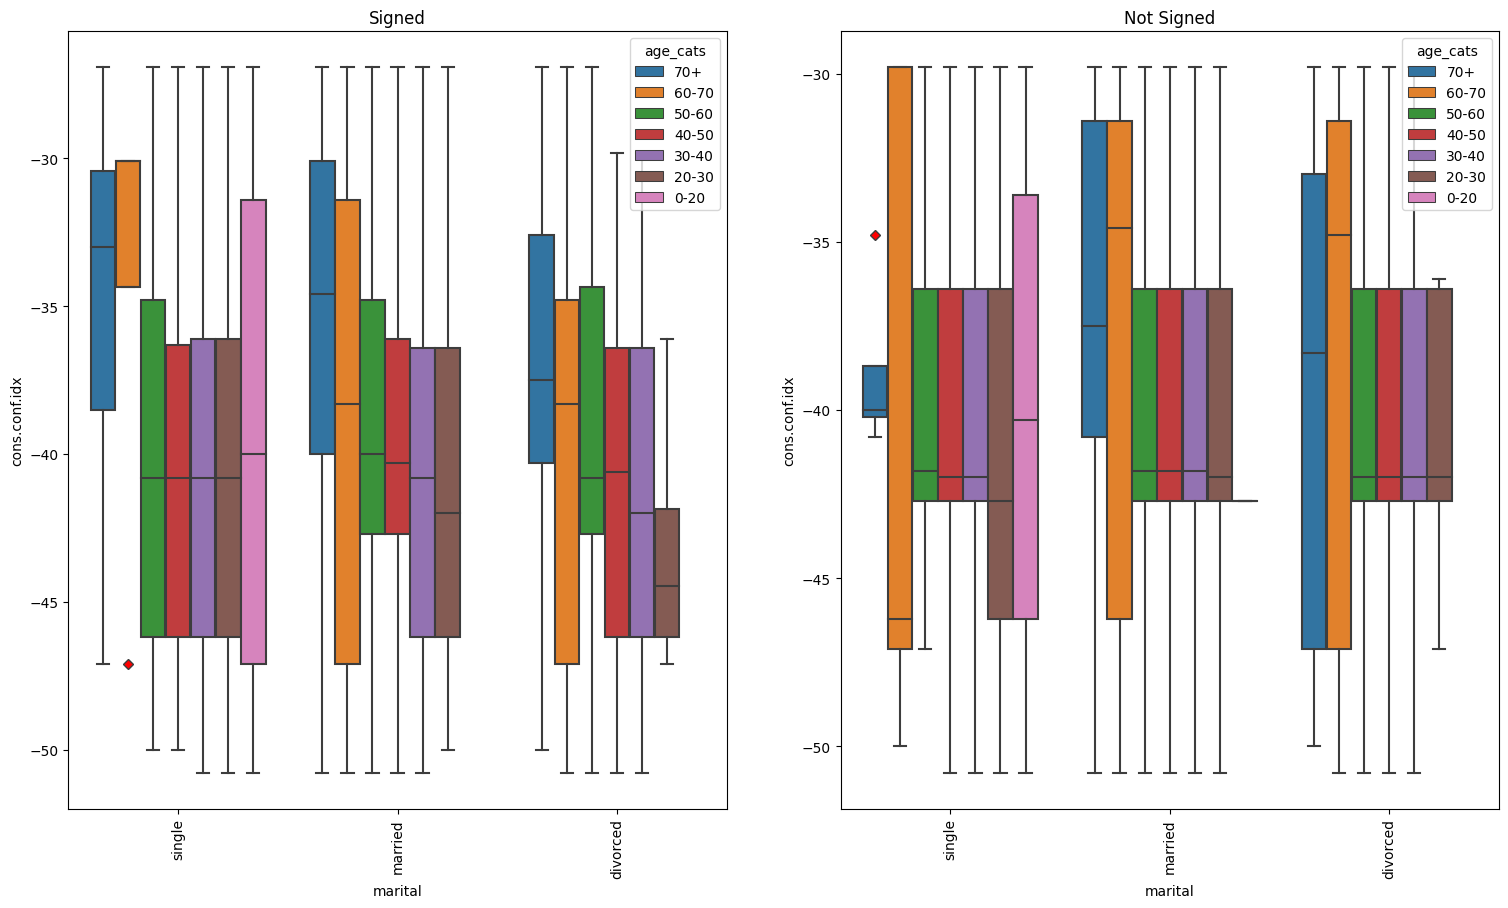

In [55]:
numeric_vs_categorical_analysis(df0, df1, "cons.conf.idx", "marital", "age_cats") 

**Singles і саме літні люди мають вищу довіру. Розлучені молоді люди мають нижчі значення, тобто реагують більш песимістично на економіку і, відповідно, менше підписують.**

count   mean  std    min    25%    50%    75%    max
education job                                                               
basic     admin.        66.00 -41.13 5.26 -50.00 -46.20 -42.35 -40.00 -26.90
          blue-collar  470.00 -41.98 4.54 -50.80 -46.20 -42.70 -39.80 -26.90
          entrepreneur  28.00 -39.85 4.90 -46.20 -42.70 -40.80 -36.40 -29.80
          housemaid     59.00 -36.77 5.34 -47.10 -40.30 -36.10 -33.00 -26.90
          management    26.00 -38.10 7.02 -50.00 -42.70 -38.10 -30.43 -26.90

count   mean  std    min    25%    50%    75%    max
education job                                                                
basic     admin.        766.00 -40.71 4.17 -50.80 -42.70 -41.80 -36.40 -26.90
          blue-collar  6897.00 -41.33 4.07 -50.80 -46.20 -42.00 -36.40 -26.90
          entrepreneur  390.00 -41.11 3.96 -50.00 -42.70 -42.00 -36.40 -26.90
          housemaid     586.00 -39.49 4.03 -50.00 -42.70 -41.80 -36.10 -26.90
          management    325.00 -40.66 4.17 -50.00 -42.70 -41.80 -36.40 -26.90

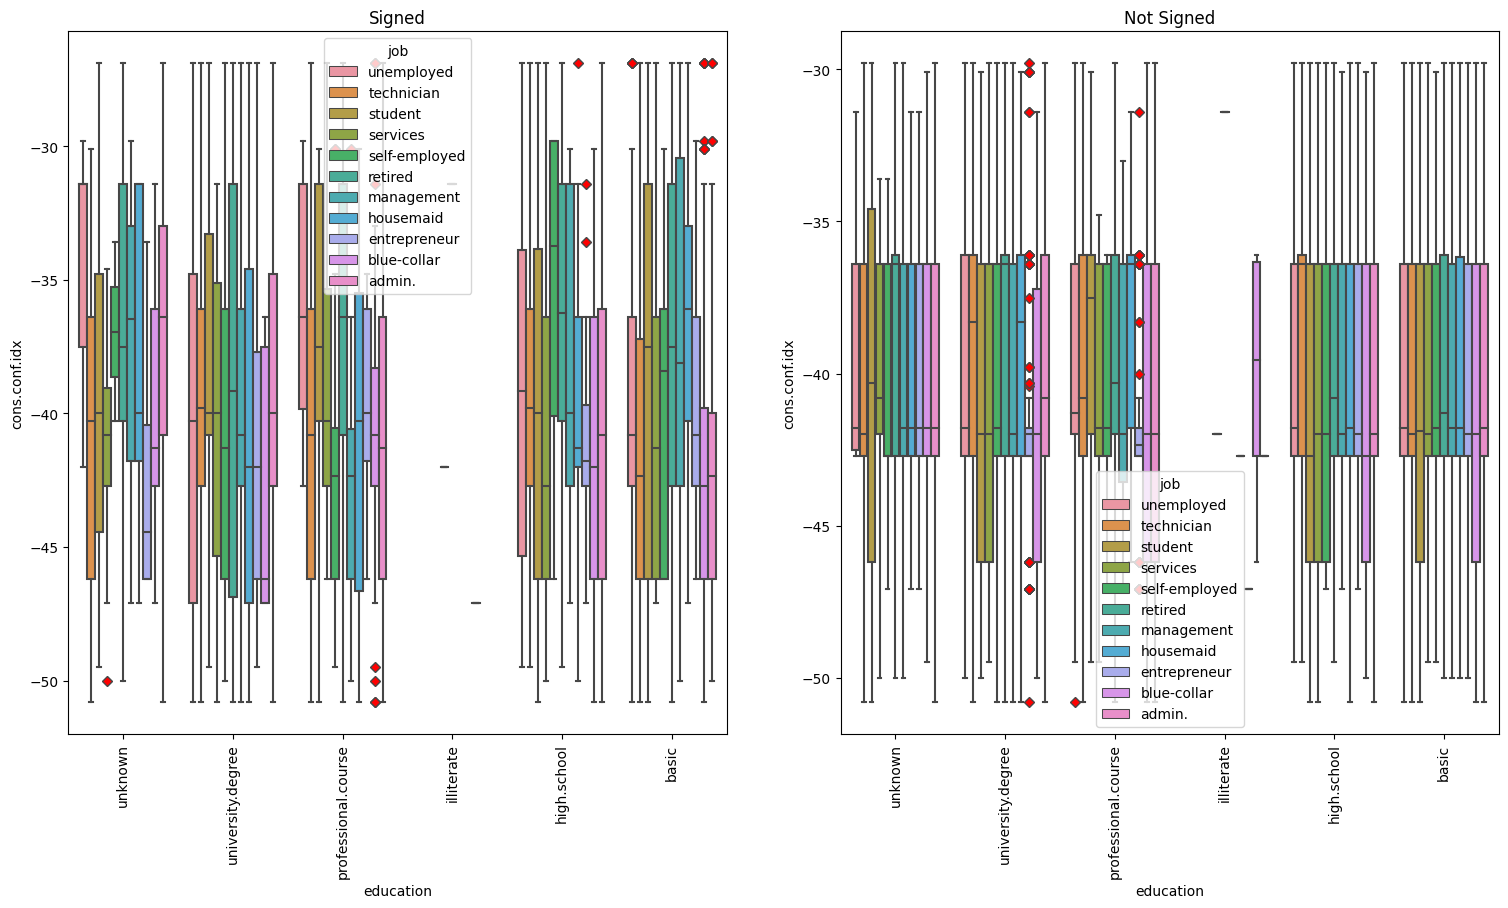

In [50]:
numeric_vs_categorical_analysis(df0, df1, "cons.conf.idx", "education", "job")

**Значення cons.conf.idx (споживча впевненість) вище у signed, у high school. Для blue-collar і admin. спостерігається нижча впевненість і менше підписів.**

In [51]:
def bi_countplot_target(df0, df1, column, hue_column) :
    group_name = f'Нормалізований розподіл значень за категорією: {column}'
    print (group_name.upper())

    pltname = 'Клієнт, який підписав'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)

    proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
      ax. bar_label(container, fmt='{:,.1f}%')

    pltname = 'Клієнти, який не підписав'
    unique_hue_values = df0[hue_column].unique()

    proportions = df0.groupby(hue_column)[column].value_counts (normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
    by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    plt.show()

    #------------
    group_name = f'Кількість значень за категорією {column}'
    print(group_name.upper())

    pltname = 'Клієнт, який підписав'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)
    counts = df1.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values [0], ascending=False
      ).plot.bar(ax=axes [0], title=pltname )

    for container in ax.containers:
      ax.bar_label(container)

    pltname = 'Клієнт, який не підписав'
    unique_hue_values = df0[hue_column].unique()
    counts = df0.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values (
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax. containers:
      ax.bar_label(container)

    plt.show()

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: CONTACT


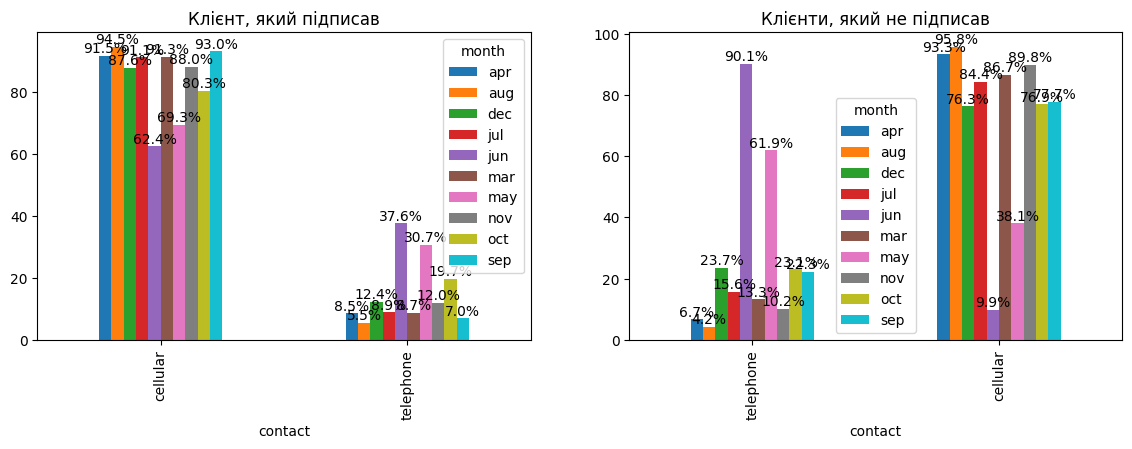

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ CONTACT


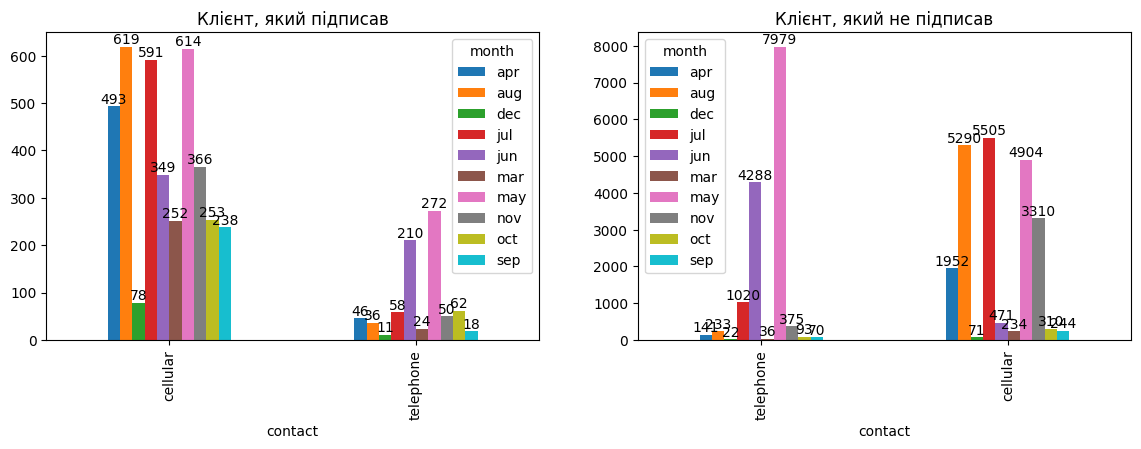

In [62]:
# Категоріальні та категоріальні змінні
bi_countplot_target(df0, df1, 'contact','month')

**Цікаво що телефонні дзвінки в травні й червні були особливо масовою кампанією, але в той же час неефективною (багато відмов).**

**Гіпотези**

- campaign: занадто багато контактів зменшує конверсію; найкраще 1–2 дзвінки

- pdays / previous / no_prev_contact: сам факт, що раніше не дзвонили (no_prev_contact=1), впливає сильніше, ніж значення pdays; клієнти з успішним минулим контактом (див. poutcome) мають вищу ймовірність y=1

- emp.var.rate, euribor3m, nr.employed: дуже сильна мультиколінеарність, нижчі ставки і гірший ринок праці = більше підписань;

- cons.conf.idx: вища споживча довіра злегка підвищує y=1 

- contact: канал cellular підвищує шанси y=1; telephone у травні/червні — антипатерн

- poutcome: минулий успіх = висока ймовірність підписання

- job, education, marital, age / age_cats: соціодемографія має середню силу; взаємодії важливіші, ніж кожна змінна окремо

- housing, loan: фінансове навантаження (іпотека/кредити) майже не змінює схильність оформити депозит

- day_of_week: не ключова фіча в порівнянні з month

# Основна частина

**Методи моделювання**

Враховуючи характер задачі та попередній EDA, доречно застосувати кілька підходів:

- Логістична регресія (проста інтерпретована модель; дозволяє перевірити гіпотези; доцільно застосувати регуляризацію, щоб впоратися з мультиколінеарністю).

- Дерева рішень / ансамблі (здатні уловлювати нелінійні залежності та взаємодії ознак; більш стійкі до викидів і дисбалансу.

- У вибірці сильний класовий дисбаланс; варто застосувати stratified sampling при крос-валідації та розглянути oversampling (SMOTE) або class_weight='balanced' у моделях.

**Метрика оцінки якості**

Оскільки дані мають сильний дисбаланс, стандартна accuracy не підходить, коректніше використати:

- ROC-AUC як основну метрику при підборі моделі (показує здатність моделі відрізняти клас 1 від класу 0 незалежно від порогу; зручний для порівняння різних моделей).

- Precision, Recall, F1-score (Recall особливо важливий, бо бізнес-ціль: не пропустити потенційних клієнтів, які можуть підписати депозит, F1-score балансує precision та recall, тож підходить для оцінки фінальної моделі).

In [95]:
X = df.drop(columns=['y', 'pdays_nan'])   
y = df['y']

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# Для логістичної: виключимо emp.var.rate, nr.employed (залишаємо euribor3m)
num_cols_lr = [c for c in num_cols if c not in ['emp.var.rate', 'nr.employed']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


preprocessor_lr = ColumnTransformer([
    ('num', StandardScaler(), num_cols_lr),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

preprocessor_knn = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

preprocessor_tree = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


models = {
    "Logistic Regression": Pipeline([
        ('preproc', preprocessor_lr),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2'))
    ]),
    
    "kNN": Pipeline([
        ('preproc', preprocessor_knn),
        ('clf', KNeighborsClassifier(n_neighbors=15))
    ]),
    
    "Decision Tree": Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, class_weight='balanced'))
    ]),
    
    "XGBoost": Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', XGBClassifier(
            n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8,
            colsample_bytree=0.8, eval_metric='logloss', use_label_encoder=False,
            scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
        ))
    ])
}


results = []

for name, model in models.items():
    print("="*50)
    print(f"Модель: {name}")
    
    # Навчання
    model.fit(X_train, y_train)
    
    # Прогнози на train
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_proba_train)
    
    # Прогнози на val
    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_proba_val)
    
    # Звіт по validation
    print(f"ROC-AUC train: {auc_train:.3f}")
    print(f"ROC-AUC val:   {auc_val:.3f}")
    print(classification_report(y_val, y_pred_val))
    
    # Зберігаємо у results
    results.append({
        "Model": name,
        "Hyperparameters": str(model.named_steps['clf']),
        "ROC-AUC train": auc_train,
        "ROC-AUC val": auc_val
    })

# Робимо таблицю результатів
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC val", ascending=False)
display(results_df)

Модель: Logistic Regression
ROC-AUC train: 0.935
ROC-AUC val:   0.943
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.45      0.90      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.88      0.76      8238
weighted avg       0.93      0.87      0.88      8238

Модель: kNN
ROC-AUC train: 0.948
ROC-AUC val:   0.924
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.69      0.41      0.51       928

    accuracy                           0.91      8238
   macro avg       0.81      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238

Модель: Decision Tree
ROC-AUC train: 0.945
ROC-AUC val:   0.945
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7310
           1       0.43      0.92      0.59      

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC train: 0.971
ROC-AUC val:   0.953
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7310
           1       0.48      0.92      0.63       928

    accuracy                           0.88      8238
   macro avg       0.73      0.90      0.78      8238
weighted avg       0.93      0.88      0.89      8238



,Model,Hyperparameters,ROC-AUC train,ROC-AUC val
3,XGBoost,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=0.8, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric='logloss',\n feature_types=None, feature_weights=None, gamma=None,\n grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.1, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=5, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=200, n_jobs=None,\n num_parallel_tree=None, ...)",0.97,0.95
2,Decision Tree,"DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n min_samples_leaf=50)",0.94,0.94
0,Logistic Regression,"LogisticRegression(class_weight='balanced', max_iter=1000)",0.93,0.94
1,kNN,KNeighborsClassifier(n_neighbors=15),0.95,0.92


In [78]:
results_detailed = [
    {
        "Model": "XGBoost",
        "Hyperparameters": "n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight≈7.9",
        "ROC-AUC train": 0.971,
        "ROC-AUC val": 0.953,
        "Comment": "Найкраща модель: високе узагальнення, добре тримає recall (0.92). Трохи просідає precision (0.48), але це прийнятно при бізнес-цілі. Варто ще тюнити n_estimators та learning_rate."
    },
    {
        "Model": "Decision Tree",
        "Hyperparameters": "max_depth=6, min_samples_leaf=50, class_weight=balanced",
        "ROC-AUC train": 0.945,
        "ROC-AUC val": 0.945,
        "Comment": "Гарний баланс, але ризик оверфіту через чутливість до гіперпараметрів. Добре ловить клас 1 (recall=0.92). Можна розвинути у Random Forest або Gradient Boosting."
    },
    {
        "Model": "Logistic Regression",
        "Hyperparameters": "penalty=L2, class_weight=balanced, max_iter=1000",
        "ROC-AUC train": 0.935,
        "ROC-AUC val": 0.943,
        "Comment": "Інтерпретована модель, стабільні метрики. Recall високий (0.90), але precision низький (0.45). Добре як базова модель. Варто протестувати L1-регуляризацію."
    },
    {
        "Model": "kNN",
        "Hyperparameters": "n_neighbors=15",
        "ROC-AUC train": 0.948,
        "ROC-AUC val": 0.924,
        "Comment": "Має кращий train AUC, але сильно втрачає recall (0.41) для класу 1, тож не підходить для дисбалансних даних. Можна протестувати інші distance metric або більший k."
    }
]

# Створюємо DataFrame
results_table = pd.DataFrame(results_detailed)

pd.set_option('display.max_colwidth', None)
# Відображення таблиці
display(results_table)

,Model,Hyperparameters,ROC-AUC train,ROC-AUC val,Comment
0,XGBoost,"n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight≈7.9",0.97,0.95,"Найкраща модель: високе узагальнення, добре тримає recall (0.92). Трохи просідає precision (0.48), але це прийнятно при бізнес-цілі. Варто ще тюнити n_estimators та learning_rate."
1,Decision Tree,"max_depth=6, min_samples_leaf=50, class_weight=balanced",0.94,0.94,"Гарний баланс, але ризик оверфіту через чутливість до гіперпараметрів. Добре ловить клас 1 (recall=0.92). Можна розвинути у Random Forest або Gradient Boosting."
2,Logistic Regression,"penalty=L2, class_weight=balanced, max_iter=1000",0.94,0.94,"Інтерпретована модель, стабільні метрики. Recall високий (0.90), але precision низький (0.45). Добре як базова модель. Варто протестувати L1-регуляризацію."
3,kNN,n_neighbors=15,0.95,0.92,"Має кращий train AUC, але сильно втрачає recall (0.41) для класу 1, тож не підходить для дисбалансних даних. Можна протестувати інші distance metric або більший k."


In [83]:
param_dist = {
    "clf__n_estimators": randint(100, 500),
    "clf__max_depth": randint(3, 10),
    "clf__learning_rate": uniform(0.01, 0.3),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4),
    "clf__gamma": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    estimator=models["XGBoost"],  
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Найкращі параметри (RandomizedSearchCV):")
print(random_search.best_params_)
print("ROC-AUC train:", roc_auc_score(y_train, random_search.predict_proba(X_train)[:,1]))
print("ROC-AUC val:", roc_auc_score(y_val, random_search.predict_proba(X_val)[:,1]))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:18:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe

Найкращі параметри (RandomizedSearchCV):
{'clf__colsample_bytree': 0.7088528997538541, 'clf__gamma': 3.238450602706812, 'clf__learning_rate': 0.010156113098594747, 'clf__max_depth': 7, 'clf__n_estimators': 332, 'clf__subsample': 0.7219125032632117}
ROC-AUC train: 0.9638270125114695
ROC-AUC val: 0.95476290155196


**Дуже збалансована модель, має низький лернінг-рейт, краща генералізація, без явного оверфіту, залишаємо як strong baseline.**

In [88]:
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 500, 25),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "gamma": hp.uniform("gamma", 0, 5)
}

def objective(params):
    
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    
    
    model = Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', XGBClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            gamma=params["gamma"],
            eval_metric='logloss',
            use_label_encoder=False,
            scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
        ))
    ])
    

    score = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
    
    return {"loss": -score, "status": STATUS_OK}


trials = Trials()
best_hyperopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=np.random.default_rng(42))

print("Найкращі параметри (Hyperopt):", best_hyperopt)

  0%|                                    | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  3%|▎        | 1/30 [00:03<01:39,  3.42s/trial, best loss: -0.9444090567608048]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  7%|▌        | 2/30 [00:06<01:37,  3.47s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 10%|▉        | 3/30 [00:09<01:19,  2.95s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 13%|█▏       | 4/30 [00:11<01:12,  2.77s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 17%|█▌       | 5/30 [00:12<00:51,  2.05s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 20%|█▊       | 6/30 [00:13<00:38,  1.61s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 23%|██       | 7/30 [00:14<00:36,  1.57s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 27%|██▍      | 8/30 [00:17<00:42,  1.92s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 30%|██▋      | 9/30 [00:18<00:34,  1.65s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 33%|██▋     | 10/30 [00:21<00:38,  1.92s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 37%|██▉     | 11/30 [00:21<00:30,  1.59s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 40%|███▏    | 12/30 [00:23<00:27,  1.52s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 43%|███▍    | 13/30 [00:25<00:27,  1.64s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 47%|███▋    | 14/30 [00:26<00:24,  1.54s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 50%|████    | 15/30 [00:27<00:22,  1.53s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 53%|████▎   | 16/30 [00:29<00:21,  1.51s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 57%|████▌   | 17/30 [00:30<00:18,  1.46s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 60%|████▊   | 18/30 [00:31<00:15,  1.28s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 63%|█████   | 19/30 [00:33<00:16,  1.48s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 67%|█████▎  | 20/30 [00:35<00:16,  1.68s/trial, best loss: -0.9465824239219455]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 70%|██████▎  | 21/30 [00:37<00:15,  1.69s/trial, best loss: -0.946621202545252]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 73%|██████▌  | 22/30 [00:39<00:14,  1.80s/trial, best loss: -0.946621202545252]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 77%|██████▏ | 23/30 [00:41<00:12,  1.82s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 80%|██████▍ | 24/30 [00:42<00:10,  1.75s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 83%|██████▋ | 25/30 [00:44<00:08,  1.72s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 87%|██████▉ | 26/30 [00:47<00:07,  1.95s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 90%|███████▏| 27/30 [00:49<00:05,  1.95s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 93%|███████▍| 28/30 [00:50<00:03,  1.76s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 97%|███████▋| 29/30 [00:51<00:01,  1.58s/trial, best loss: -0.9468299365844004]

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:25:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


100%|████████| 30/30 [00:53<00:00,  1.78s/trial, best loss: -0.9468299365844004]
Найкращі параметри (Hyperopt): {'colsample_bytree': 0.96098438227139, 'gamma': 3.2270942835921983, 'learning_rate': 0.013594100414947104, 'max_depth': 9.0, 'n_estimators': 225.0, 'subsample': 0.6685637358882777}


In [89]:
best_params = {
    "n_estimators": int(best_hyperopt["n_estimators"]),
    "max_depth": int(best_hyperopt["max_depth"]),
    "learning_rate": best_hyperopt["learning_rate"],
    "subsample": best_hyperopt["subsample"],
    "colsample_bytree": best_hyperopt["colsample_bytree"],
    "gamma": best_hyperopt["gamma"],
}

xgb_hyperopt = Pipeline([
    ('preproc', preprocessor_tree),
    ('clf', XGBClassifier(
        **best_params,
        eval_metric="logloss",
        use_label_encoder=False,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42
    ))
])

xgb_hyperopt.fit(X_train, y_train)

y_proba_train = xgb_hyperopt.predict_proba(X_train)[:,1]
y_proba_val = xgb_hyperopt.predict_proba(X_val)[:,1]

print("ROC-AUC train:", roc_auc_score(y_train, y_proba_train))
print("ROC-AUC val:", roc_auc_score(y_val, y_proba_val))

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:26:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC train: 0.973733642714606
ROC-AUC val: 0.9539517636445115


**Дещо вищий train AUC (ризик оверфіту), але val AUC майже ідентичний RandomizedSearch. Схоже, Hyperopt підштовхнув модель до більшої складності.**

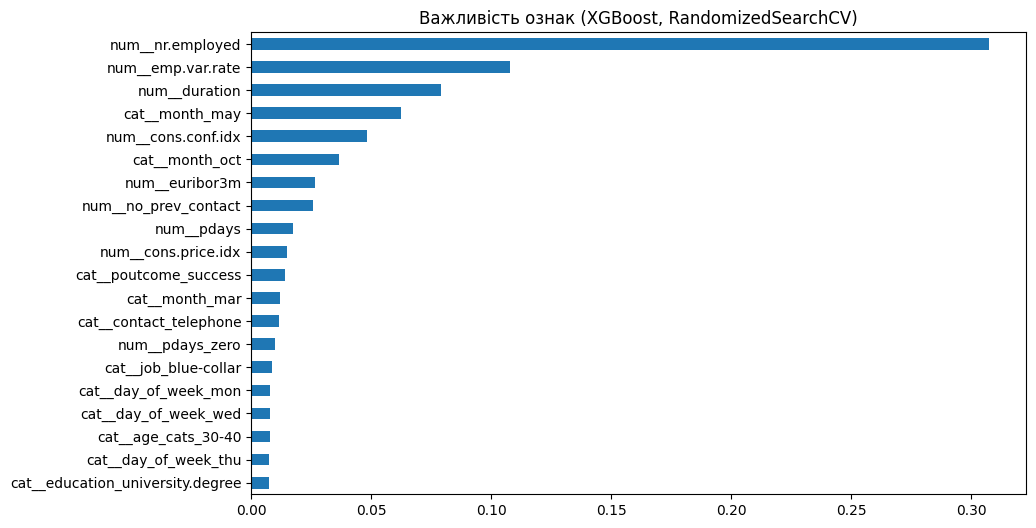

num__nr.employed                   0.31
num__emp.var.rate                  0.11
num__duration                      0.08
cat__month_may                     0.06
num__cons.conf.idx                 0.05
cat__month_oct                     0.04
num__euribor3m                     0.03
num__no_prev_contact               0.03
num__pdays                         0.02
num__cons.price.idx                0.01
cat__poutcome_success              0.01
cat__month_mar                     0.01
cat__contact_telephone             0.01
num__pdays_zero                    0.01
cat__job_blue-collar               0.01
cat__day_of_week_mon               0.01
cat__day_of_week_wed               0.01
cat__age_cats_30-40                0.01
cat__day_of_week_thu               0.01
cat__education_university.degree   0.01
dtype: float32

In [90]:
# Беремо кращу модель з RandomizedSearchCV
best_xgb = random_search.best_estimator_

xgb_clf = best_xgb.named_steps['clf']

feature_names = (
    best_xgb.named_steps['preproc']
    .get_feature_names_out()
)

importances = pd.Series(xgb_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind='barh')
plt.title("Важливість ознак (XGBoost, RandomizedSearchCV)")
plt.gca().invert_yaxis()
plt.show()

importances.head(20)

**Спостереження**

- nr.employed - це макроіндикатор рівня зайнятості. Логічно, що коли на ринку праці краще (більше зайнятих), люди менше прагнуть до депозитів. Дуже адекватно, що він у топі.

- emp.var.rate - коли економіка падає, люди більше схильні вкладати у безпечні депозити.

- duration - важлива, але непридатна для продакшену.

- month_may - відображає сезонність, в кампаній наймасовіші, проте не завжди ефективні дзвінки.

- cons.conf.idx - бачили, що нижча довіра трохи підштовхує до депозитів.

- pdays - через багато 999 більш шумний показник, ніж просто “був/не був контакт”.

- poutcome_success – успіх минулої кампанії, ніби має бути сильнішим фактором, тому дещо дивує, що воно так низько. Можливо, з’їдається кореляціями з іншими ознаками.

Загалом макроекономічні змінні, сезонність, індекс довіри адекватно у топі, а дні тижня та демографія — на низьких позиціях, що цілком логічно.

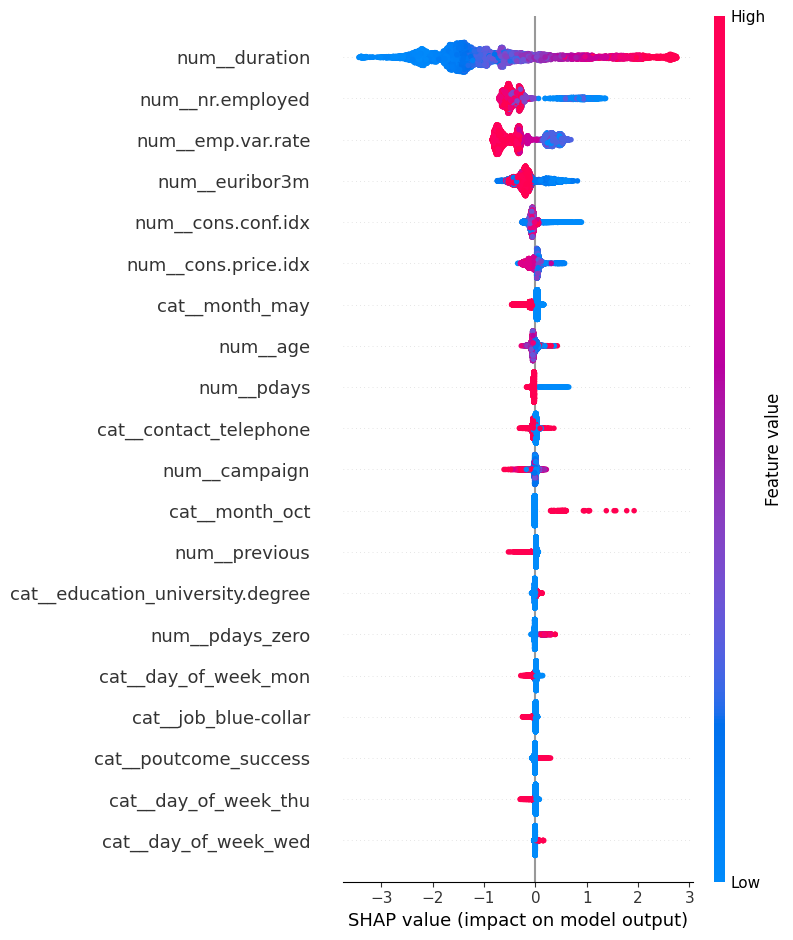

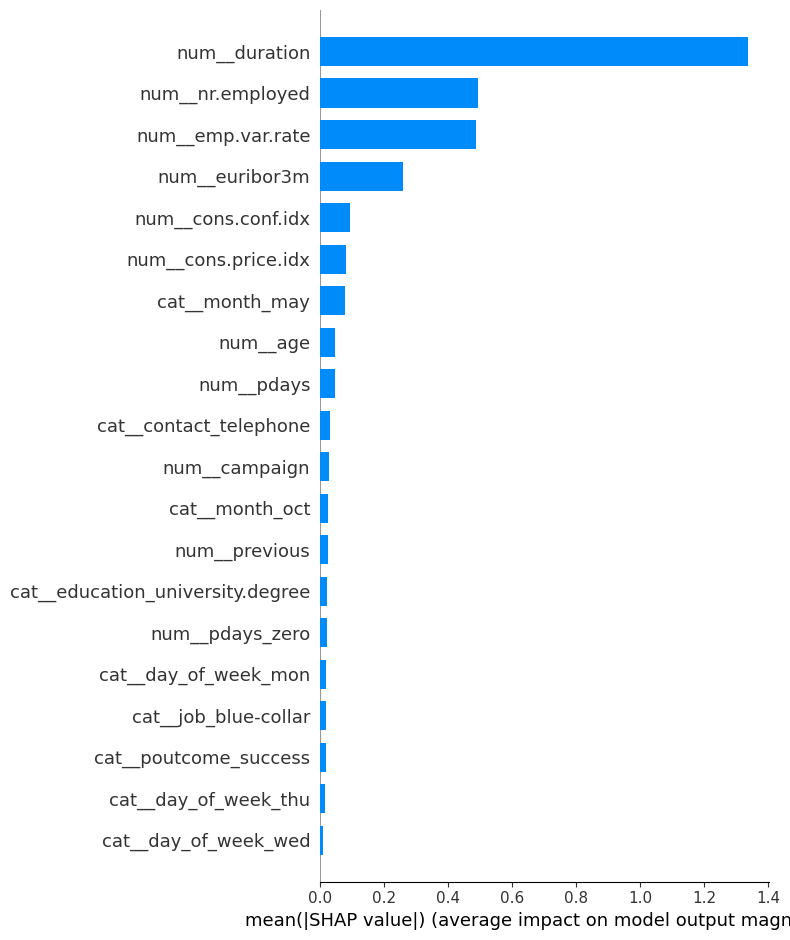

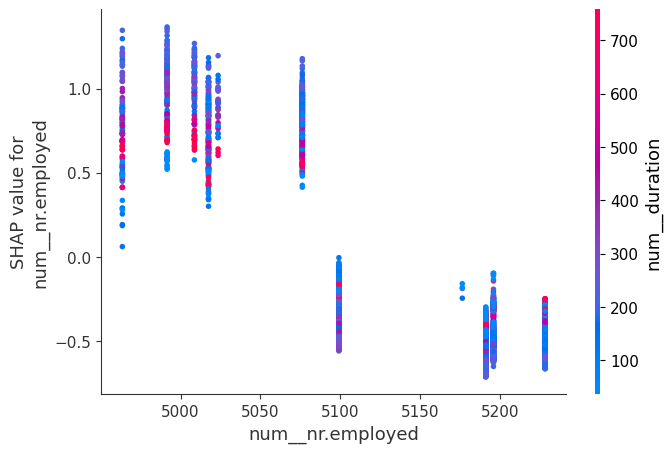

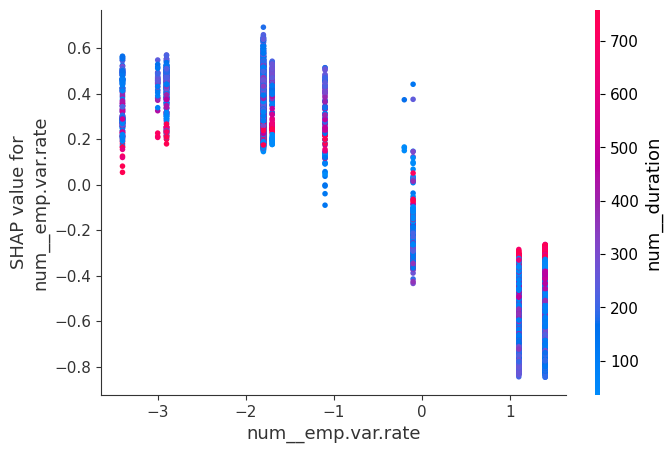

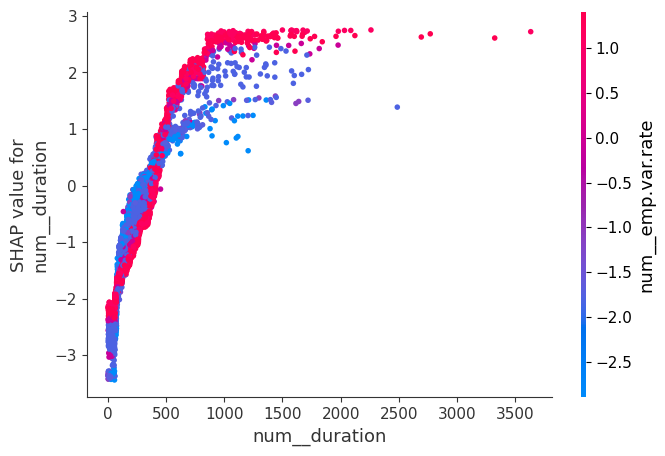

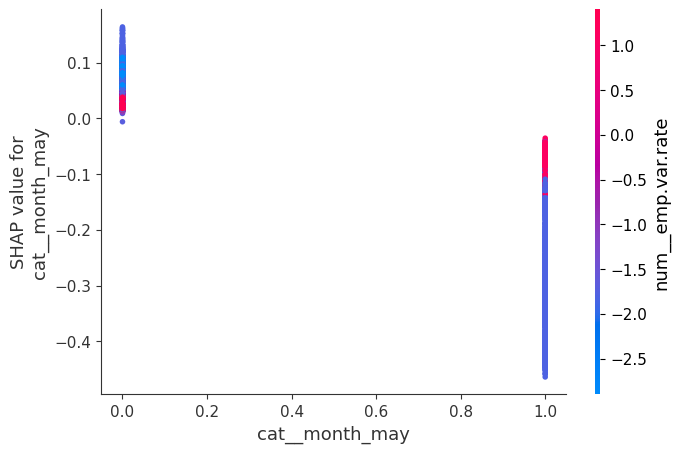

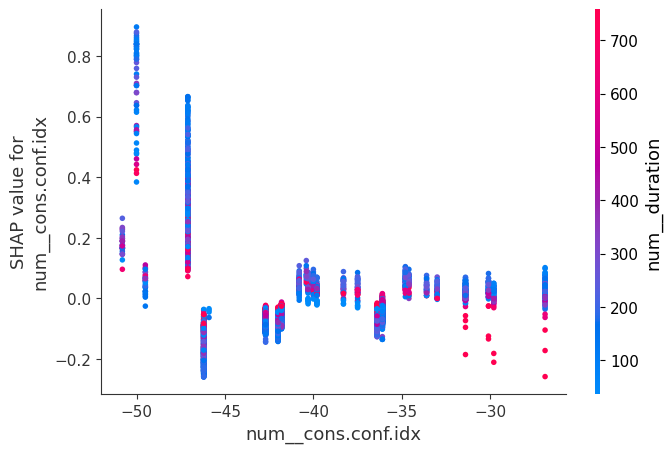

In [99]:
best_model = random_search.best_estimator_

preprocessor = best_model.named_steps['preproc']
xgb_clf = best_model.named_steps['clf']

# Трансформуємо вхідні дані
X_val_transformed = preprocessor.transform(X_val)
feature_names = preprocessor.get_feature_names_out()

# Ініціалізуємо explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_val_transformed)

# Summary plot (глобальна важливість)
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names)

# Beeswarm plot
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names, plot_type="bar")

# Dependence plot для топових ознак
top_features = pd.Series(xgb_clf.feature_importances_, index=feature_names).sort_values(ascending=False).head(5).index
for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_val_transformed, feature_names=feature_names)

**SHAP підтвердив результати EDA. Ключовий фактор – тривалість контакту. Далі – макроекономічний фон (зайнятість, ставки, зростання/спад), сезонність (місяць, зокрема травень). Соціодемографія (job, education, marital) відіграє другорядну роль. Це адекватно з точки зору common sense, адже модель вловила саме ті сигнали, які і справді впливають на реальну поведінку клієнтів.**

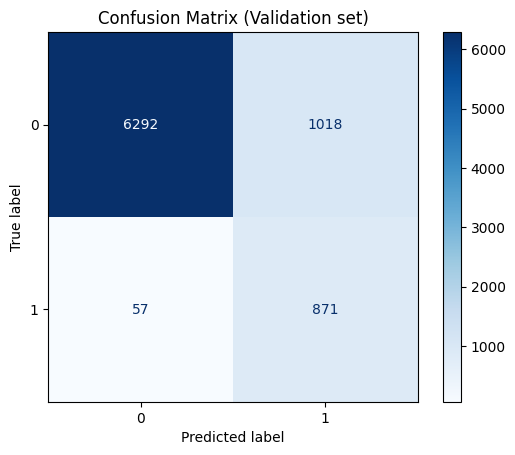

False Positives: 1018
False Negatives: 57

=== JOB ===
False Positives:
admin.        0.29
technician    0.16
blue-collar   0.14
retired       0.09
services      0.08
Name: job, dtype: float64
False Negatives:
blue-collar   0.25
admin.        0.25
services      0.12
technician    0.12
management    0.09
Name: job, dtype: float64

=== EDUCATION ===
False Positives:
university.degree     0.36
basic                 0.26
high.school           0.20
professional.course   0.13
unknown               0.05
Name: education, dtype: float64
False Negatives:
basic                 0.33
university.degree     0.33
high.school           0.19
professional.course   0.14
Name: education, dtype: float64

=== CONTACT ===
False Positives:
cellular    0.78
telephone   0.22
Name: contact, dtype: float64
False Negatives:
cellular    0.70
telephone   0.30
Name: contact, dtype: float64

=== MONTH ===
False Positives:
may   0.21
apr   0.15
aug   0.14
jun   0.14
jul   0.14
Name: month, dtype: float64
False Negatives

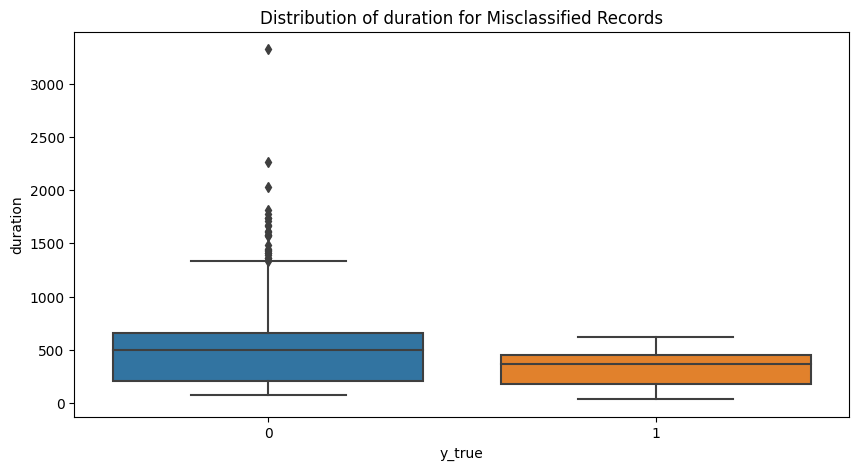

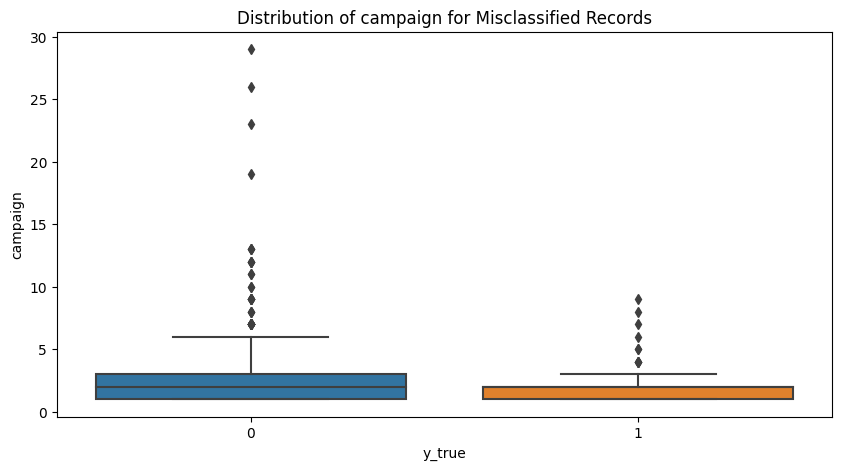

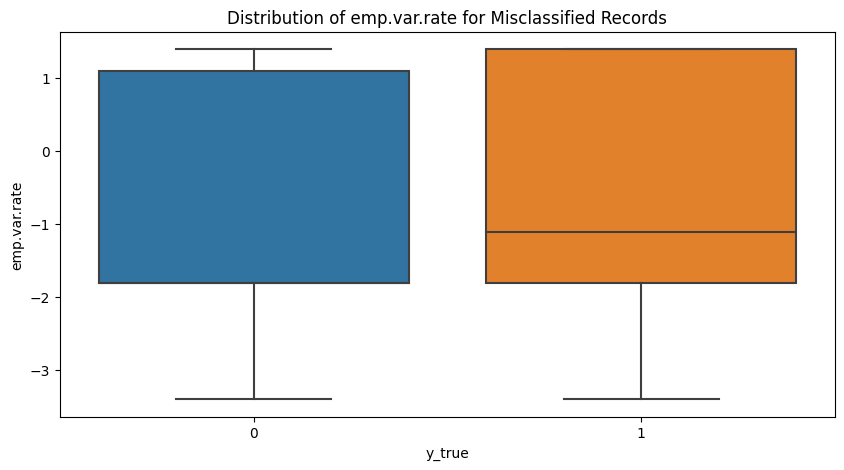

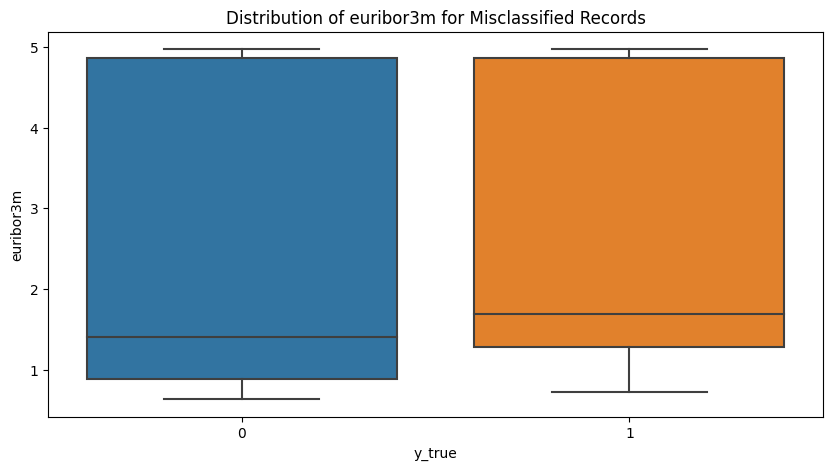

In [108]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation set)")
plt.show()

val_results = X_val.copy()
val_results["y_true"] = y_val
val_results["y_pred"] = y_pred_val
val_results["y_proba"] = y_proba_val

false_positives = val_results[(val_results["y_true"] == 0) & (val_results["y_pred"] == 1)]
false_negatives = val_results[(val_results["y_true"] == 1) & (val_results["y_pred"] == 0)]

print("False Positives:", false_positives.shape[0])
print("False Negatives:", false_negatives.shape[0])

# Категоріальні змінні
for col in ["job", "education", "contact", "month"]:
    print(f"\n=== {col.upper()} ===")
    print("False Positives:")
    print(false_positives[col].value_counts(normalize=True).head())
    print("False Negatives:")
    print(false_negatives[col].value_counts(normalize=True).head())

# Числові змінні
num_vars = ["duration", "campaign", "emp.var.rate", "euribor3m"]
for col in num_vars:
    plt.figure(figsize=(10,5))
    sns.boxplot(x="y_true", y=col, data=val_results[val_results["y_true"] != val_results["y_pred"]])
    plt.title(f"Distribution of {col} for Misclassified Records")
    plt.show()

**Проблема**

Багато FP (модель занадто оптимістично вважає, що клієнт підпише депозит). Щодо числових ознак, цікаво що в макроданих модель не завжди «розуміє», чи людина зреагує на депозит. В категоріальних, admin., technician, blue-collar часто плутають модель, випускники університетів та з basic освітою, ті хто з cellular. Травень особливо проблемний як місяць, бо масові кампанії в цей період давали високий рівень помилок.


**Як покращити модель**

- Балансування класів (можна підняти поріг decision threshold, щоб модель менше помилялася з «yes»)

- Feature engineering (обмежити вплив duration, перетворити campaign на категоріальну ознаку: 1 дзвінок, 2-3 дзвінки...)

- Більш гнучкі моделі (використати ансамблі, наприклад Stacking: LR + Tree + XGB)

- Тюнінг метрик (якщо бізнес-мета мінімізувати FP, краще оптимізувати Precision-Recall замість ROC-AUC)